# Sandesh Brand 4 discovery

This notebook will explore the data and do the hyperparameter optimization for the trining process.

## Load the libraries

In [1]:
import sys
# sys.path.append('/home/jupyter/Sandesh_brand_4/codes/')

In [2]:

import os
import pandas as pd
import numpy as np
import warnings
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
warnings.filterwarnings("ignore")
from datetime import datetime
from dateutil import relativedelta
import utils as utils
import conf as conf

In [3]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(10)

In [4]:
import mape_raw_score_calculation

## Data Loading

In [5]:
data = utils.get_dataframe()

In [6]:
data

Generic Group                                  Generic Brand  \
0     Segment 2  Sandesh Brand 1 / Sandesh Brand 2 - Segment 2   
1     Segment 2  Sandesh Brand 1 / Sandesh Brand 2 - Segment 2   
2     Segment 2  Sandesh Brand 1 / Sandesh Brand 2 - Segment 2   
3     Segment 2  Sandesh Brand 1 / Sandesh Brand 2 - Segment 2   

  Generic Product Category Generic Product  Generic Group variable  \
0                Broadband           Falcon                   ARPU   
1                Broadband           Falcon                   ARPU   
2                Broadband           Falcon                 Volume   
3                Broadband           Falcon                 Volume   

                                 Generic Variable Generic Sub-Variable  \
0       Average revenue per new customer - Falcon  Intentionally Blank   
1  Average revenue per existing customer - Falcon  Intentionally Blank   
2                       Gross Adds - Falcon(Norm)  Intentionally Blank   
3                   Net Migrations - Falcon(Norm)  Intentionally Blank   

                                   Generic LookupKey   Units  \
0  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...  Pounds   
1  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...  Pounds   
2  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...  (000)s   
3  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...  (000)s   

   2016-04-01 00:00:00  ...  2019-06-01 00:00:00  2019-07-01 00:00:00  \
0             0.107120  ...            -1.446524            -1.058759   
1            -0.728341  ...             1.099112             1.016346   
2            -1.557326  ...             1.971281             0.094823   
3            -1.328065  ...             1.102364             1.355811   

   2019-08-01 00:00:00  2019-09-01 00:00:00  2019-10-01 00:00:00  \
0            -1.372266            -1.715756            -1.651663   
1             0.551219             0.099310             0.009180   
2             0.910060             1.867112             1.233778   
3             1.268435             2.142191             1.806576   

   2019-11-01 00:00:00  2019-12-01 00:00:00  2020-01-01 00:00:00  \
0            -1.442524            -1.754209            -1.345226   
1             0.033835            -0.228040            -0.519837   
2             1.702771             0.087836             1.383145   
3             1.749406             1.271329             2.439615   

   2020-02-01 00:00:00  2020-03-01 00:00:00  
0            -1.671763            -1.976966  
1            -1.403620            -1.883290  
2             0.215232             1.643264  
3             1.659137             1.650920  

[4 rows x 57 columns]

In [7]:
# Get relevant columns and mould it into specific format further training and prediction
time_series_values_start = 9
X = np.array(data[data.columns[time_series_values_start:]].values)
X = X.T
X = pd.DataFrame(X)
X.columns = list(data["Generic LookupKey"])
X["time"] = data.columns[time_series_values_start:]
X = X.set_index("time")

In [8]:
X

Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon  \
time                                                                                                                         
2016-04-01                                           0.107120                                                                
2016-05-01                                           0.075391                                                                
2016-06-01                                           0.271979                                                                
2016-07-01                                           0.505065                                                                
2016-08-01                                           0.277726                                                                
2016-09-01                                           0.349048                                                                
2016-10-01                                           0.256174                                                                
2016-11-01                                          -0.010638                                                                
2016-12-01                                          -0.139911                                                                
2017-01-01                                          -0.088569                                                                
2017-02-01                                          -0.213121                                                                
2017-03-01                                          -0.084838                                                                
2017-04-01                                           0.877792                                                                
2017-05-01                                           0.738473                                                                
2017-06-01                                           1.094789                                                                
2017-07-01                                           1.019152                                                                
2017-08-01                                           1.004420                                                                
2017-09-01                                           1.224478                                                                
2017-10-01                                           1.031359                                                                
2017-11-01                                           0.910344                                                                
2017-12-01                                           1.003089                                                                
2018-01-01                                           1.331898                                                                
2018-02-01                                           1.690535                                                                
2018-03-01                                           1.830892                                                                
2018-04-01                                          -1.275699                                                                
2018-05-01                                          -0.763002                                                                
2018-06-01                                          -0.173952                                                                
2018-07-01                                           0.105664                                                                
2018-08-01                                           0.167189                                                                
2018-09-01                                           0.447716                                             

In [9]:
## The columns which will be forecasted
cols_to_predict = list(X.columns.values)

In [10]:
X.index

DatetimeIndex(['2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01',
               '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01',
               '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01',
               '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
               '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01',
               '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01',
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01',
               '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01',
               '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01',
               '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01'],
              dtype='datetime64[ns]', name='time', freq=None)

In [11]:
## Dataframe is set as month start data
X.index.freq = 'MS'

In [12]:
X.columns

Index(['Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon',
       'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon',
       'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)',
       'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)'],
      dtype='object')

In [13]:
## Take what is needed
X = X[cols_to_predict]

## Outlier Detection

For outlier detection, IForest method is used. Top 8% anomaly are detected among all the data points. Outliers detected are then smoothed by using rolling mean value of 2 months.

In [14]:
X

Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon  \
time                                                                                                                         
2016-04-01                                           0.107120                                                                
2016-05-01                                           0.075391                                                                
2016-06-01                                           0.271979                                                                
2016-07-01                                           0.505065                                                                
2016-08-01                                           0.277726                                                                
2016-09-01                                           0.349048                                                                
2016-10-01                                           0.256174                                                                
2016-11-01                                          -0.010638                                                                
2016-12-01                                          -0.139911                                                                
2017-01-01                                          -0.088569                                                                
2017-02-01                                          -0.213121                                                                
2017-03-01                                          -0.084838                                                                
2017-04-01                                           0.877792                                                                
2017-05-01                                           0.738473                                                                
2017-06-01                                           1.094789                                                                
2017-07-01                                           1.019152                                                                
2017-08-01                                           1.004420                                                                
2017-09-01                                           1.224478                                                                
2017-10-01                                           1.031359                                                                
2017-11-01                                           0.910344                                                                
2017-12-01                                           1.003089                                                                
2018-01-01                                           1.331898                                                                
2018-02-01                                           1.690535                                                                
2018-03-01                                           1.830892                                                                
2018-04-01                                          -1.275699                                                                
2018-05-01                                          -0.763002                                                                
2018-06-01                                          -0.173952                                                                
2018-07-01                                           0.105664                                                                
2018-08-01                                           0.167189                                                                
2018-09-01                                           0.447716                                             

In [15]:
## The columns which will not be smoothed
excptn_2_smooth = []

In [16]:
## Step Outlier smoothing columns
step_cols = ['Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon']

  0%|          | 0/4 [00:00<?, ?it/s]

Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon


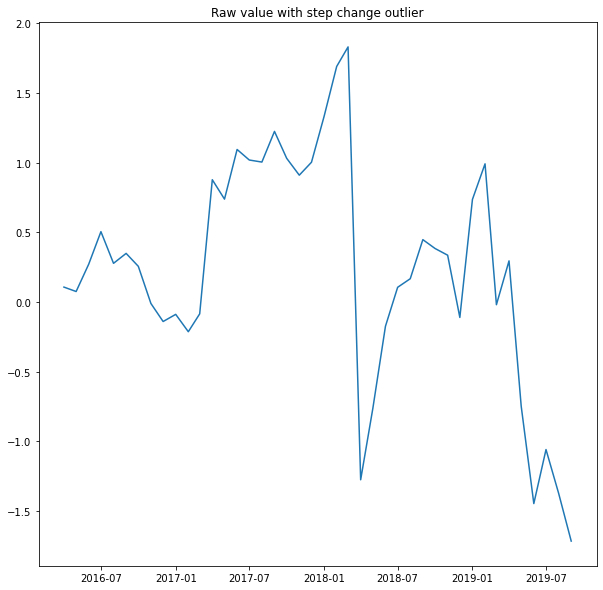

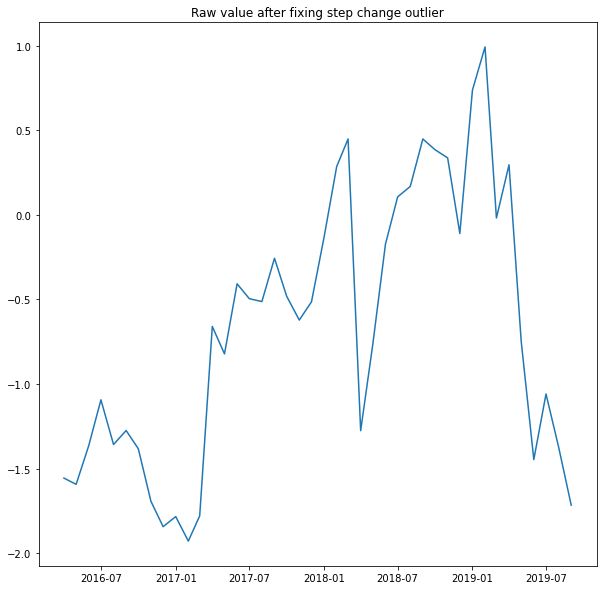

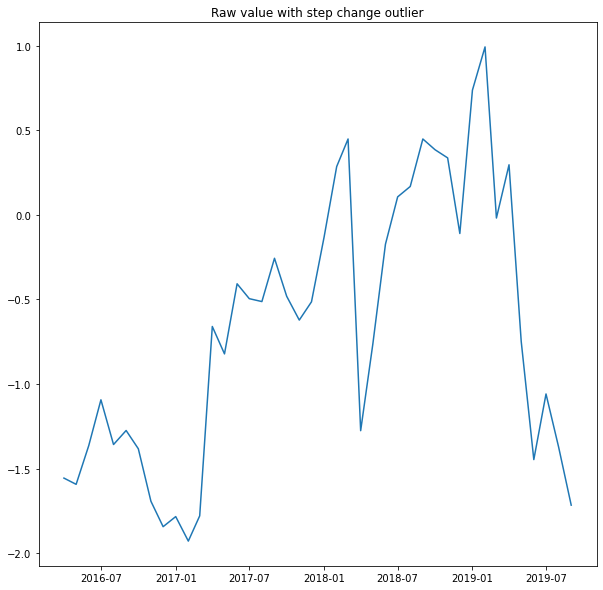

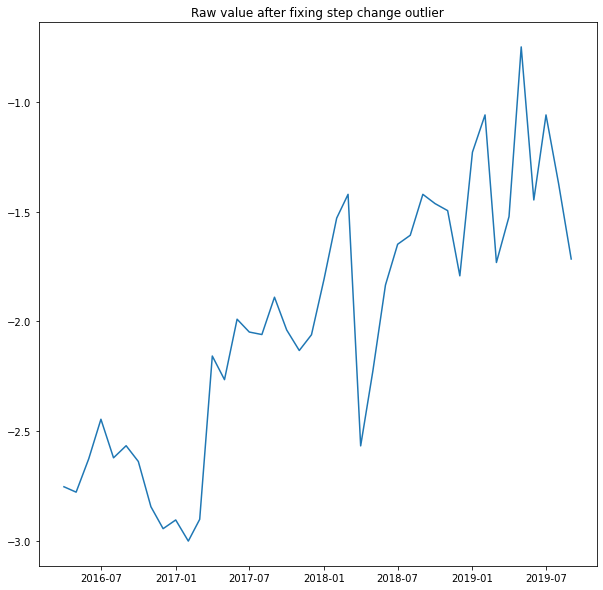

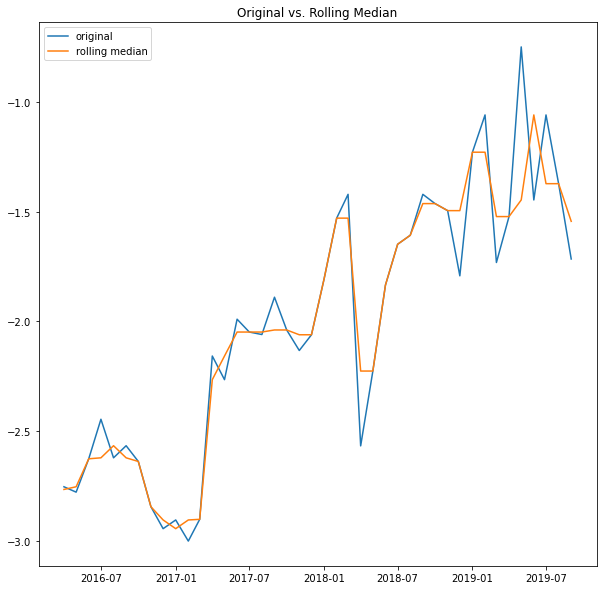

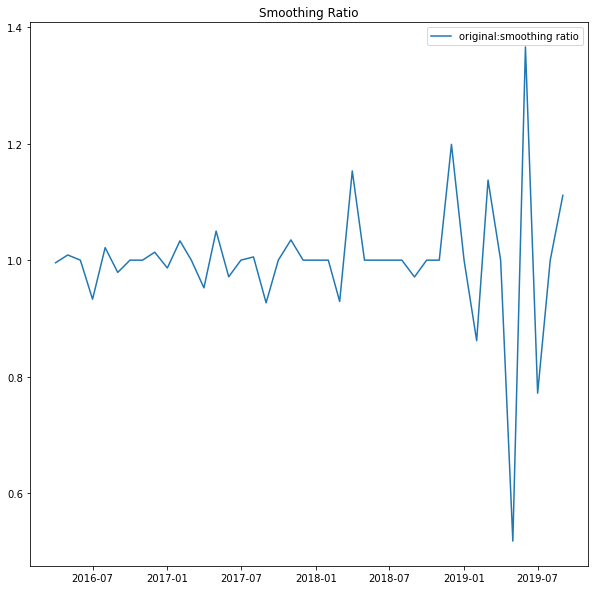

Outliers found at  DatetimeIndex(['2016-07-01', '2016-08-01', '2016-09-01', '2016-12-01',
               '2017-01-01', '2017-02-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-08-01', '2017-09-01', '2017-11-01',
               '2018-03-01', '2018-04-01', '2018-09-01', '2018-12-01',
               '2019-02-01', '2019-03-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-09-01'],
              dtype='datetime64[ns]', name='time', freq=None)


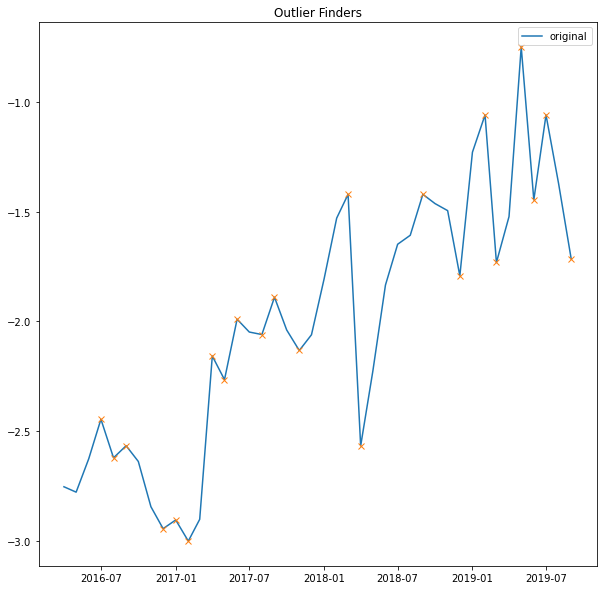

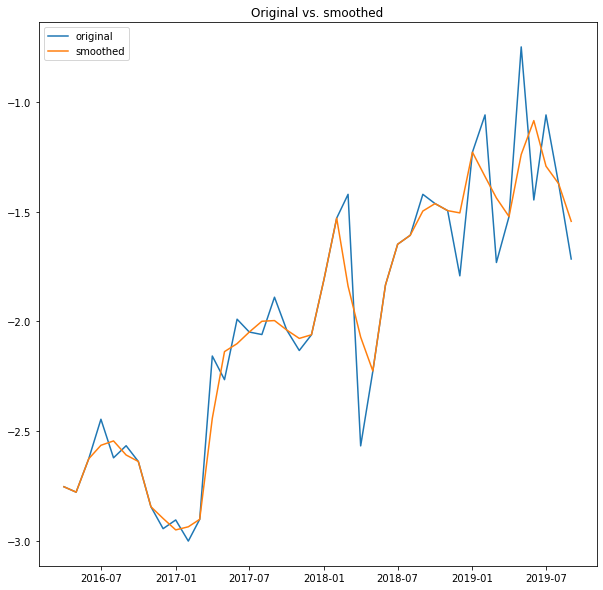

 25%|██▌       | 1/4 [00:01<00:04,  1.57s/it]

Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon


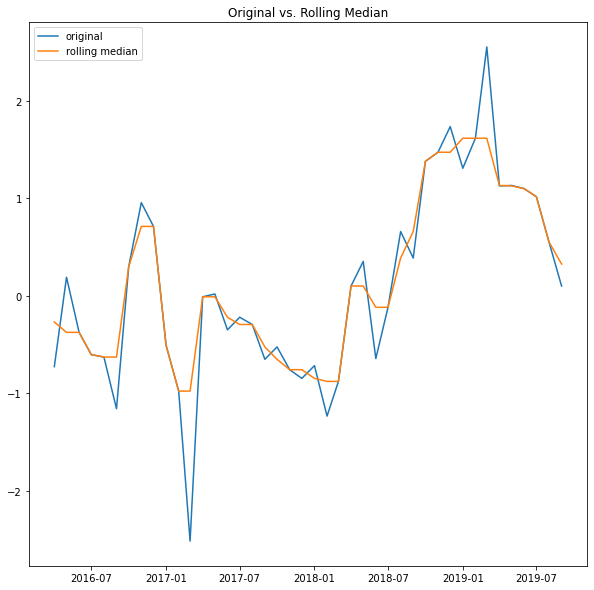

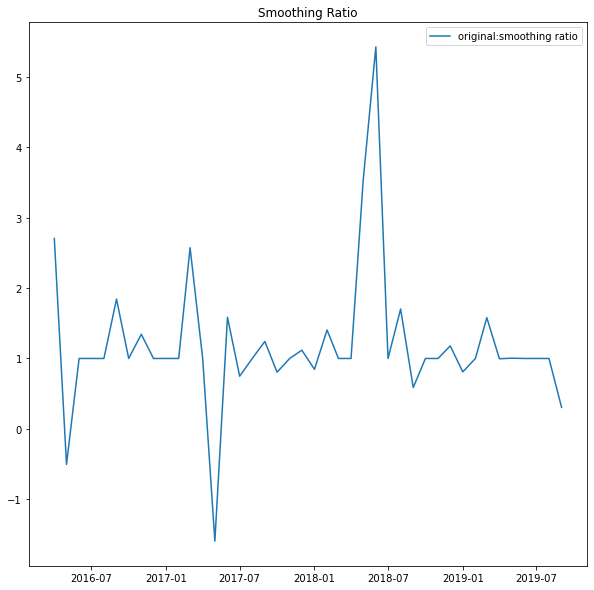

Outliers found at  DatetimeIndex(['2016-09-01', '2016-11-01', '2017-03-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-09-01', '2017-10-01',
               '2017-12-01', '2018-01-01', '2018-02-01', '2018-05-01',
               '2018-06-01', '2018-08-01', '2018-09-01', '2018-12-01',
               '2019-01-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-09-01'],
              dtype='datetime64[ns]', name='time', freq=None)


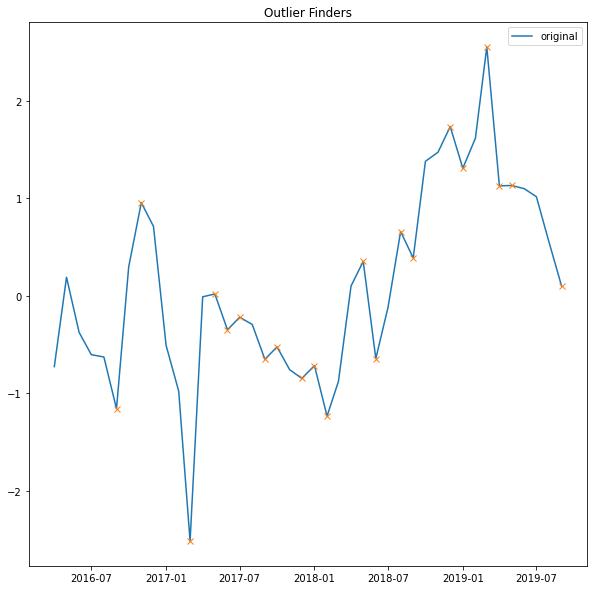

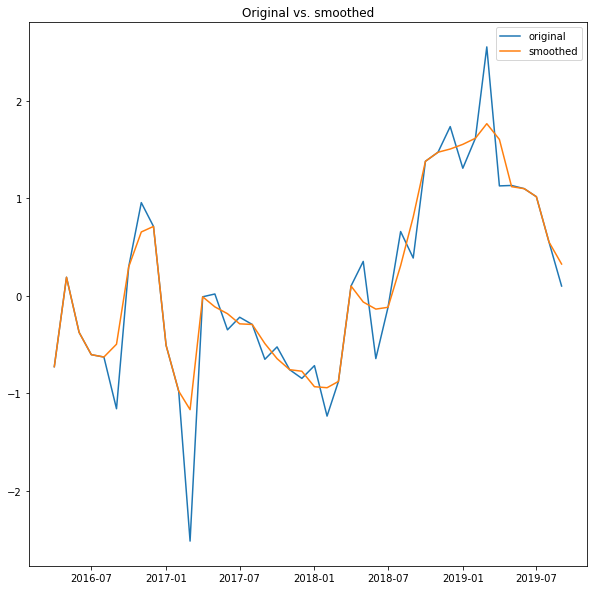

 50%|█████     | 2/4 [00:02<00:02,  1.43s/it]

Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)


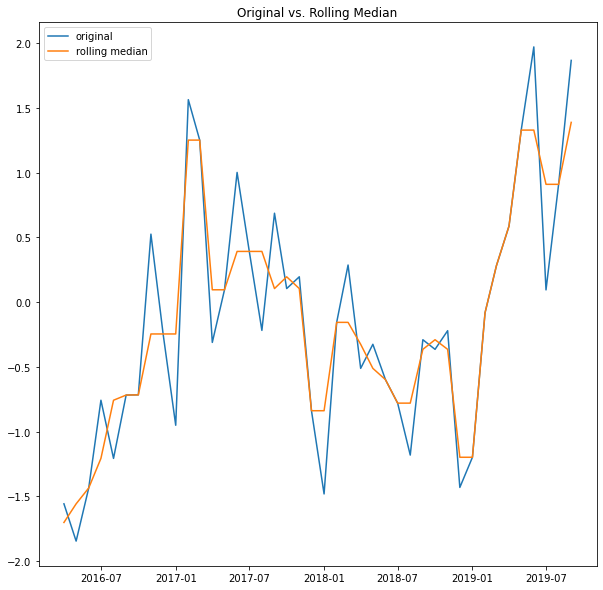

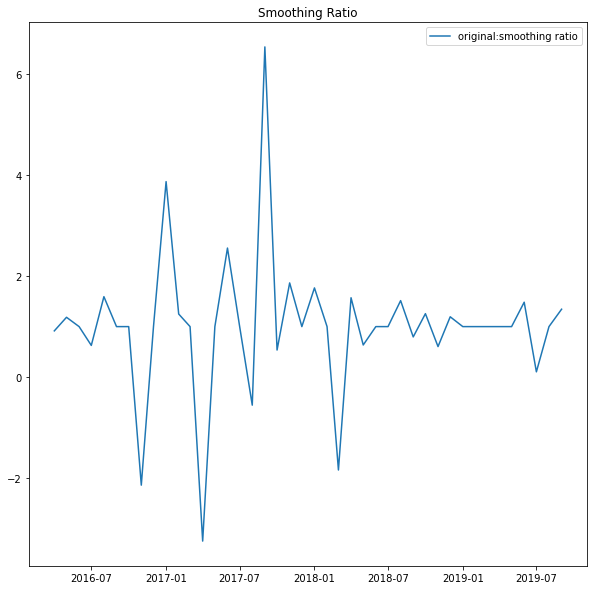

Outliers found at  DatetimeIndex(['2016-07-01', '2016-08-01', '2016-11-01', '2017-01-01',
               '2017-02-01', '2017-04-01', '2017-06-01', '2017-08-01',
               '2017-09-01', '2017-10-01', '2017-11-01', '2018-01-01',
               '2018-03-01', '2018-04-01', '2018-05-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-06-01', '2019-07-01', '2019-09-01'],
              dtype='datetime64[ns]', name='time', freq=None)


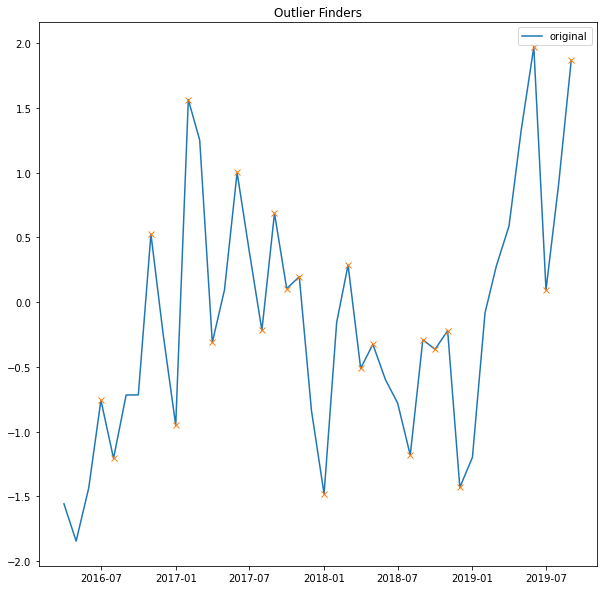

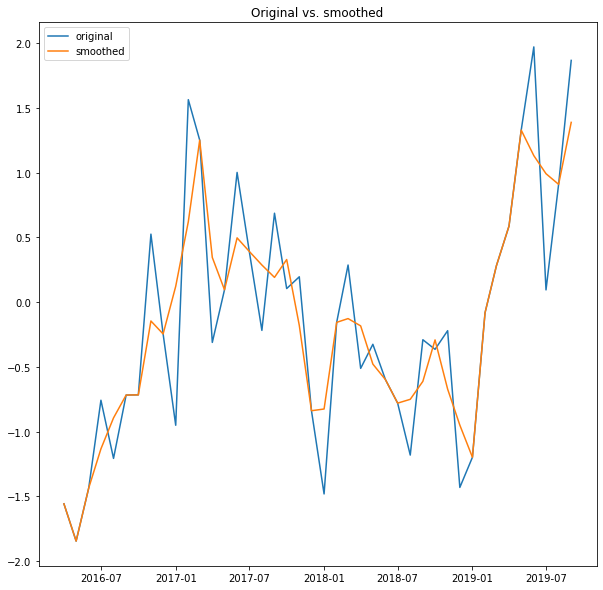

 75%|███████▌  | 3/4 [00:03<00:01,  1.31s/it]

Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)


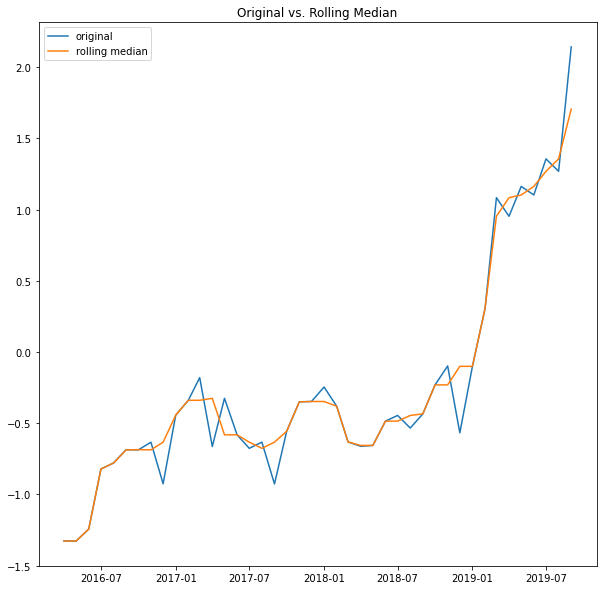

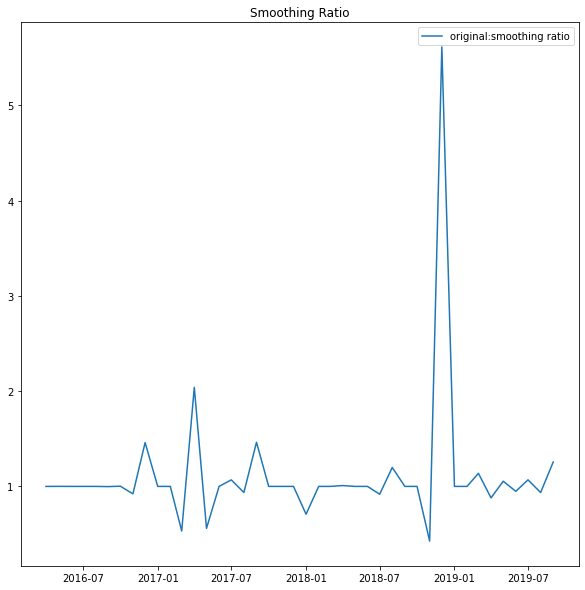

Outliers found at  DatetimeIndex(['2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01',
               '2017-03-01', '2017-04-01', '2017-05-01', '2017-07-01',
               '2017-08-01', '2017-09-01', '2018-01-01', '2018-04-01',
               '2018-07-01', '2018-08-01', '2018-11-01', '2018-12-01',
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01'],
              dtype='datetime64[ns]', name='time', freq=None)


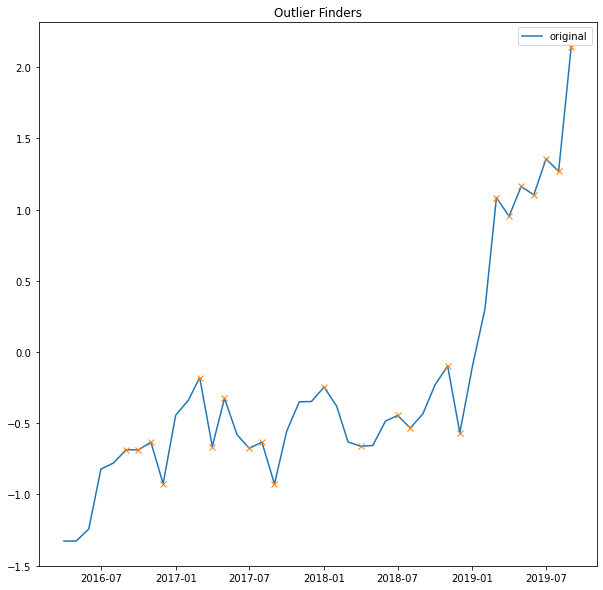

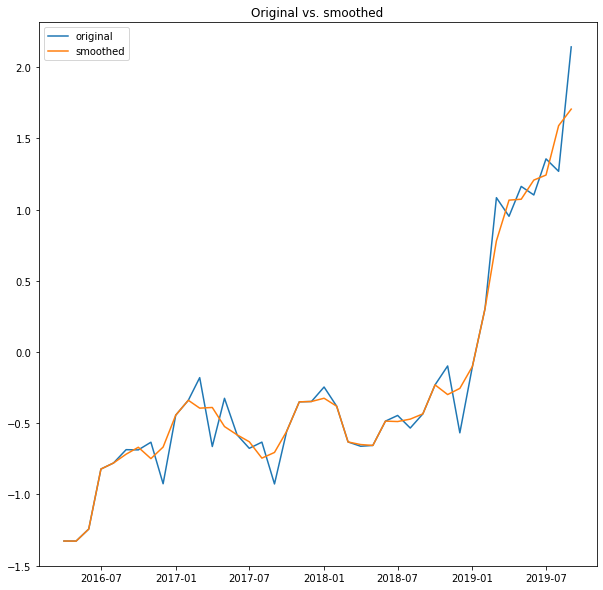

100%|██████████| 4/4 [00:04<00:00,  1.14s/it]


In [17]:
## Outlier smoothing done here
smoothed_data = []
for col in tqdm(cols_to_predict):
    print(col)
    temp_X = X[~X[col].isnull()]
    temp_X = temp_X['2016-04-01':'2019-09-01']
    temp_X[col] = pd.to_numeric(temp_X[col])
    temp_X_col = temp_X[col]
    if np.any(np.array(step_cols)==col):
        temp_X_col = utils.fix_step_change(temp_X_col,
                                           step_change_date='2018-03-01',
                                           post_step_change_start='2018-04-01',
                                           corrected_step_max = '2018-09-01')
        temp_X_col = utils.fix_step_change(temp_X_col,
                                           step_change_date='2019-04-01',
                                           post_step_change_start='2019-05-01',
                                           corrected_step_max = '2019-07-01')
    if np.any(np.array(excptn_2_smooth)==col): 
        temp_X_smoothed = temp_X_col.copy()
    else:
        temp_X_smoothed = utils.outlier_smoothing(temp_X_col, contamination=0.6)
    
    smoothed_data.append(temp_X_smoothed)

In [18]:
len(smoothed_data)

4

In [19]:
smoothed_data_df = pd.DataFrame(pd.concat(smoothed_data, axis=1).values, columns=cols_to_predict)

In [20]:
smoothed_data_df.set_index(X['2016-04-01':'2019-09-01'].index.values, inplace=True)

In [21]:
smoothed_data_df

Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon  \
2016-04-01                                          -2.754465                                                                
2016-05-01                                          -2.779012                                                                
2016-06-01                                          -2.626921                                                                
2016-07-01                                          -2.565329                                                                
2016-08-01                                          -2.545454                                                                
2016-09-01                                          -2.609639                                                                
2016-10-01                                          -2.639148                                                                
2016-11-01                                          -2.845569                                                                
2016-12-01                                          -2.899004                                                                
2017-01-01                                          -2.951221                                                                
2017-02-01                                          -2.937019                                                                
2017-03-01                                          -2.902974                                                                
2017-04-01                                          -2.442406                                                                
2017-05-01                                          -2.138198                                                                
2017-06-01                                          -2.101743                                                                
2017-07-01                                          -2.048866                                                                
2017-08-01                                          -1.999714                                                                
2017-09-01                                          -1.996566                                                                
2017-10-01                                          -2.039422                                                                
2017-11-01                                          -2.077920                                                                
2017-12-01                                          -2.061292                                                                
2018-01-01                                          -1.806908                                                                
2018-02-01                                          -1.529446                                                                
2018-03-01                                          -1.839439                                                                
2018-04-01                                          -2.071873                                                                
2018-05-01                                          -2.226748                                                                
2018-06-01                                          -1.834659                                                                
2018-07-01                                          -1.648538                                                                
2018-08-01                                          -1.607585                                                                
2018-09-01                                          -1.497186                                                                
2018-10-01                                          -1.463114                                             

## Feature Engineering

In [22]:
# Import model
import model as model
import feature_preprocessing as feat_proc

In [23]:
list_val_df = []
for col in smoothed_data_df.columns:
    val = smoothed_data_df.reset_index().rename(columns={"index":"time"}).loc[:,["time",col]].values
    val_df = pd.DataFrame(val)
    val_df["metric"] = col
    list_val_df.append(val_df)

In [24]:
smoothed_val_df_regr = \
pd.concat(list_val_df).rename(columns={0:"time",
                                       1:"val"
                                      })

In [25]:
smoothed_val_df_regr

time      val                                             metric
0  2016-04-01 -2.75446  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...
1  2016-05-01 -2.77901  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...
2  2016-06-01 -2.62692  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...
3  2016-07-01 -2.56533  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...
4  2016-08-01 -2.54545  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...
..        ...      ...                                                ...
37 2019-05-01  1.07243  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...
38 2019-06-01  1.20687  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...
39 2019-07-01   1.2422  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...
40 2019-08-01  1.58881  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...
41 2019-09-01  1.70531  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...

[168 rows x 3 columns]

In [26]:
smoothed_val_df_rolled = \
feat_proc.get_rolling_dataframe(smoothed_val_df_regr,
                                column_id="metric",
                                column_sort="time",
                                max_timeshift=3,
                                min_timeshift=3,
                                n_jobs=8
                               )

Rolling: 100%|██████████| 21/21 [00:00<00:00, 189.91it/s]


In [27]:
smoothed_val_df_rolled.val

0     -0.728341
1      0.189526
208    0.189526
2     -0.376269
209   -0.376269
         ...   
589      1.2422
623      1.2422
575     1.58881
590     1.58881
591     1.70531
Name: val, Length: 624, dtype: object

In [28]:
smoothed_val_df_rolled[smoothed_val_df_rolled.val.isna()]

Empty DataFrame
Columns: [time, val, metric, id]
Index: []

In [29]:
smoothed_val_df_rolled_X = \
feat_proc.get_features_dataframe(smoothed_val_df_rolled.drop("metric",axis=1),
                        column_id="id", column_sort="time", 
                        column_value="val",
                        fcparams="minimal"
                        )

Feature Extraction: 100%|██████████| 39/39 [00:00<00:00, 4899.30it/s]


In [30]:
smoothed_val_df_rolled_X

variable                                            val__length  val__maximum  \
id                                                                              
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...          4.0      0.189526   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...          4.0      0.189526   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...          4.0     -0.376269   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...          4.0      0.296251   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...          4.0      0.654437   
...                                                         ...           ...   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...          4.0      1.072429   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...          4.0      1.206868   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...          4.0      1.242204   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...          4.0      1.588812   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...          4.0      1.705313   

variable                                            val__mean  val__median  \
id                                                                           
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...  -0.380082    -0.490756   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...  -0.355392    -0.490756   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...  -0.527248    -0.551571   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...  -0.359118    -0.551571   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...  -0.044198    -0.100824   
...                                                       ...          ...   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...   0.805740     0.923061   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...   1.031355     1.069246   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...   1.146891     1.139648   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...   1.277578     1.224536   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...   1.435799     1.415508   

variable                                            val__minimum  \
id                                                                 
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...     -0.728341   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...     -0.629582   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...     -0.629582   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...     -0.629582   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...     -0.629582   
...                                                          ...   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...      0.304411   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...      0.780058   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...      1.066064   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...      1.072429   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...      1.206868   

variable                                            val__standard_deviation  \
id                                                                            
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...                 0.352296   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...                 0.329764   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...                 0.100264   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...                 0.381608   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...                 0.536776   
...                                                                     ...   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...                 0.312603   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...                 0.155601   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...                 0.078676   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...                 0.190528   
id=Segment 2Sandesh Brand 1 / Sandesh Brand 2 -...                 0.215604   

variable          

In [31]:
smoothed_val_df_rolled_X["metric"] = \
pd.Series(smoothed_val_df_rolled_X.index.values).\
apply(lambda x: x.split(",")[0].split("=")[1]).values

smoothed_val_df_rolled_X["timeshift_id"] = \
pd.Series(smoothed_val_df_rolled_X.index.values).\
apply(lambda x: x.split(",")[1].split("=")[1]).values

smoothed_val_df_rolled_X.reset_index(drop=True, inplace=True)

smoothed_val_df_rolled_X["timeshift_id"] = \
pd.to_datetime(smoothed_val_df_rolled_X["timeshift_id"]).dt.date


In [32]:
smoothed_val_df_rolled_X

variable  val__length  val__maximum  val__mean  val__median  val__minimum  \
0                 4.0      0.189526  -0.380082    -0.490756     -0.728341   
1                 4.0      0.189526  -0.355392    -0.490756     -0.629582   
2                 4.0     -0.376269  -0.527248    -0.551571     -0.629582   
3                 4.0      0.296251  -0.359118    -0.551571     -0.629582   
4                 4.0      0.654437  -0.044198    -0.100824     -0.629582   
..                ...           ...        ...          ...           ...   
151               4.0      1.072429   0.805740     0.923061      0.304411   
152               4.0      1.206868   1.031355     1.069246      0.780058   
153               4.0      1.242204   1.146891     1.139648      1.066064   
154               4.0      1.588812   1.277578     1.224536      1.072429   
155               4.0      1.705313   1.435799     1.415508      1.206868   

variable  val__standard_deviation  val__sum_values  val__variance  \
0                        0.352296        -1.520327       0.124112   
1                        0.329764        -1.421568       0.108744   
2                        0.100264        -2.108993       0.010053   
3                        0.381608        -1.436473       0.145624   
4                        0.536776        -0.176793       0.288129   
..                            ...              ...            ...   
151                      0.312603         3.222962       0.097720   
152                      0.155601         4.125418       0.024212   
153                      0.078676         4.587563       0.006190   
154                      0.190528         5.110312       0.036301   
155                      0.215604         5.743197       0.046485   

variable                                             metric timeshift_id  
0         Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2016-07-01  
1         Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2016-08-01  
2         Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2016-09-01  
3         Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2016-10-01  
4         Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2016-11-01  
..                                                      ...          ...  
151       Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2019-05-01  
152       Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2019-06-01  
153       Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2019-07-01  
154       Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2019-08-01  
155       Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2019-09-01  

[156 rows x 10 columns]

In [33]:
smoothed_val_df_regr["time"] = pd.to_datetime(smoothed_val_df_regr["time"]).dt.date

In [34]:
smoothed_val_transformed_df = \
pd.merge(smoothed_val_df_rolled_X,smoothed_val_df_regr,
            how="inner",
            right_on=["metric","time"],
            left_on=["metric","timeshift_id"]
            )

In [35]:
smoothed_val_transformed_df

val__length  val__maximum  val__mean  val__median  val__minimum  \
0            4.0      0.189526  -0.380082    -0.490756     -0.728341   
1            4.0      0.189526  -0.355392    -0.490756     -0.629582   
2            4.0     -0.376269  -0.527248    -0.551571     -0.629582   
3            4.0      0.296251  -0.359118    -0.551571     -0.629582   
4            4.0      0.654437  -0.044198    -0.100824     -0.629582   
..           ...           ...        ...          ...           ...   
151          4.0      1.072429   0.805740     0.923061      0.304411   
152          4.0      1.206868   1.031355     1.069246      0.780058   
153          4.0      1.242204   1.146891     1.139648      1.066064   
154          4.0      1.588812   1.277578     1.224536      1.072429   
155          4.0      1.705313   1.435799     1.415508      1.206868   

     val__standard_deviation  val__sum_values  val__variance  \
0                   0.352296        -1.520327       0.124112   
1                   0.329764        -1.421568       0.108744   
2                   0.100264        -2.108993       0.010053   
3                   0.381608        -1.436473       0.145624   
4                   0.536776        -0.176793       0.288129   
..                       ...              ...            ...   
151                 0.312603         3.222962       0.097720   
152                 0.155601         4.125418       0.024212   
153                 0.078676         4.587563       0.006190   
154                 0.190528         5.110312       0.036301   
155                 0.215604         5.743197       0.046485   

                                                metric timeshift_id  \
0    Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2016-07-01   
1    Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2016-08-01   
2    Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2016-09-01   
3    Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2016-10-01   
4    Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2016-11-01   
..                                                 ...          ...   
151  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2019-05-01   
152  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2019-06-01   
153  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2019-07-01   
154  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2019-08-01   
155  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2019-09-01   

           time       val  
0    2016-07-01 -0.605243  
1    2016-08-01 -0.629582  
2    2016-09-01 -0.497899  
3    2016-10-01  0.296251  
4    2016-11-01  0.654437  
..          ...       ...  
151  2019-05-01   1.07243  
152  2019-06-01   1.20687  
153  2019-07-01    1.2422  
154  2019-08-01   1.58881  
155  2019-09-01   1.70531  

[156 rows x 12 columns]

In [36]:
smoothed_val_transformed_df["target_val"] = \
smoothed_val_transformed_df.groupby("metric")["val"].shift(-1)

In [37]:
smoothed_val_transformed_df

val__length  val__maximum  val__mean  val__median  val__minimum  \
0            4.0      0.189526  -0.380082    -0.490756     -0.728341   
1            4.0      0.189526  -0.355392    -0.490756     -0.629582   
2            4.0     -0.376269  -0.527248    -0.551571     -0.629582   
3            4.0      0.296251  -0.359118    -0.551571     -0.629582   
4            4.0      0.654437  -0.044198    -0.100824     -0.629582   
..           ...           ...        ...          ...           ...   
151          4.0      1.072429   0.805740     0.923061      0.304411   
152          4.0      1.206868   1.031355     1.069246      0.780058   
153          4.0      1.242204   1.146891     1.139648      1.066064   
154          4.0      1.588812   1.277578     1.224536      1.072429   
155          4.0      1.705313   1.435799     1.415508      1.206868   

     val__standard_deviation  val__sum_values  val__variance  \
0                   0.352296        -1.520327       0.124112   
1                   0.329764        -1.421568       0.108744   
2                   0.100264        -2.108993       0.010053   
3                   0.381608        -1.436473       0.145624   
4                   0.536776        -0.176793       0.288129   
..                       ...              ...            ...   
151                 0.312603         3.222962       0.097720   
152                 0.155601         4.125418       0.024212   
153                 0.078676         4.587563       0.006190   
154                 0.190528         5.110312       0.036301   
155                 0.215604         5.743197       0.046485   

                                                metric timeshift_id  \
0    Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2016-07-01   
1    Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2016-08-01   
2    Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2016-09-01   
3    Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2016-10-01   
4    Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2016-11-01   
..                                                 ...          ...   
151  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2019-05-01   
152  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2019-06-01   
153  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2019-07-01   
154  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2019-08-01   
155  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2019-09-01   

           time       val target_val  
0    2016-07-01 -0.605243  -0.629582  
1    2016-08-01 -0.629582  -0.497899  
2    2016-09-01 -0.497899   0.296251  
3    2016-10-01  0.296251   0.654437  
4    2016-11-01  0.654437   0.711331  
..          ...       ...        ...  
151  2019-05-01   1.07243    1.20687  
152  2019-06-01   1.20687     1.2422  
153  2019-07-01    1.2422    1.58881  
154  2019-08-01   1.58881    1.70531  
155  2019-09-01   1.70531        NaN  

[156 rows x 13 columns]

In [38]:
smoothed_val_transformed_df.drop(["time","val"],axis=1,inplace=True)

In [39]:
smoothed_val_transformed_df.dropna(inplace=True)

In [40]:
smoothed_val_transformed_df

val__length  val__maximum  val__mean  val__median  val__minimum  \
0            4.0      0.189526  -0.380082    -0.490756     -0.728341   
1            4.0      0.189526  -0.355392    -0.490756     -0.629582   
2            4.0     -0.376269  -0.527248    -0.551571     -0.629582   
3            4.0      0.296251  -0.359118    -0.551571     -0.629582   
4            4.0      0.654437  -0.044198    -0.100824     -0.629582   
..           ...           ...        ...          ...           ...   
150          4.0      1.066064   0.512328     0.542235     -0.101220   
151          4.0      1.072429   0.805740     0.923061      0.304411   
152          4.0      1.206868   1.031355     1.069246      0.780058   
153          4.0      1.242204   1.146891     1.139648      1.066064   
154          4.0      1.588812   1.277578     1.224536      1.072429   

     val__standard_deviation  val__sum_values  val__variance  \
0                   0.352296        -1.520327       0.124112   
1                   0.329764        -1.421568       0.108744   
2                   0.100264        -2.108993       0.010053   
3                   0.381608        -1.436473       0.145624   
4                   0.536776        -0.176793       0.288129   
..                       ...              ...            ...   
150                 0.446647         2.049313       0.199493   
151                 0.312603         3.222962       0.097720   
152                 0.155601         4.125418       0.024212   
153                 0.078676         4.587563       0.006190   
154                 0.190528         5.110312       0.036301   

                                                metric timeshift_id target_val  
0    Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2016-07-01  -0.629582  
1    Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2016-08-01  -0.497899  
2    Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2016-09-01   0.296251  
3    Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2016-10-01   0.654437  
4    Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2016-11-01   0.711331  
..                                                 ...          ...        ...  
150  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2019-04-01    1.07243  
151  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2019-05-01    1.20687  
152  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2019-06-01     1.2422  
153  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2019-07-01    1.58881  
154  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...   2019-08-01    1.70531  

[152 rows x 11 columns]

In [41]:
## Feature Engineered data starting from 2017-04-01
X_eng, y = model.process_train(smoothed_data_df['2016-04-01':])

Data shape: (42, 64)


In [42]:

X_eng_price = X_eng.copy()

In [43]:
X_eng_price

Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon_prev_value  \
2016-04-01                                          -2.754465                                                                           
2016-05-01                                          -2.779012                                                                           
2016-06-01                                          -2.626921                                                                           
2016-07-01                                          -2.565329                                                                           
2016-08-01                                          -2.545454                                                                           
2016-09-01                                          -2.609639                                                                           
2016-10-01                                          -2.639148                                                                           
2016-11-01                                          -2.845569                                                                           
2016-12-01                                          -2.899004                                                                           
2017-01-01                                          -2.951221                                                                           
2017-02-01                                          -2.937019                                                                           
2017-03-01                                          -2.902974                                                                           
2017-04-01                                          -2.442406                                                                           
2017-05-01                                          -2.138198                                                                           
2017-06-01                                          -2.101743                                                                           
2017-07-01                                          -2.048866                                                                           
2017-08-01                                          -1.999714                                                                           
2017-09-01                                          -1.996566                                                                           
2017-10-01                                          -2.039422                                                                           
2017-11-01                                          -2.077920                                                                           
2017-12-01                                          -2.061292                                                                           
2018-01-01                                          -1.806908                                                                           
2018-02-01                                          -1.529446                                                                           
2018-03-01                                          -1.839439                                                                           
2018-04-01                                          -2.071873                                                                           
2018-05-01                                          -2.226748                                                                           
2018-06-01                                          -1.834659                                                                           
2018-07-01                                          -1.648538                                                                           
2018-08-01                             

In [44]:
y

Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon  \
2016-04-01                                          -2.754465                                                                
2016-05-01                                          -2.779012                                                                
2016-06-01                                          -2.626921                                                                
2016-07-01                                          -2.565329                                                                
2016-08-01                                          -2.545454                                                                
2016-09-01                                          -2.609639                                                                
2016-10-01                                          -2.639148                                                                
2016-11-01                                          -2.845569                                                                
2016-12-01                                          -2.899004                                                                
2017-01-01                                          -2.951221                                                                
2017-02-01                                          -2.937019                                                                
2017-03-01                                          -2.902974                                                                
2017-04-01                                          -2.442406                                                                
2017-05-01                                          -2.138198                                                                
2017-06-01                                          -2.101743                                                                
2017-07-01                                          -2.048866                                                                
2017-08-01                                          -1.999714                                                                
2017-09-01                                          -1.996566                                                                
2017-10-01                                          -2.039422                                                                
2017-11-01                                          -2.077920                                                                
2017-12-01                                          -2.061292                                                                
2018-01-01                                          -1.806908                                                                
2018-02-01                                          -1.529446                                                                
2018-03-01                                          -1.839439                                                                
2018-04-01                                          -2.071873                                                                
2018-05-01                                          -2.226748                                                                
2018-06-01                                          -1.834659                                                                
2018-07-01                                          -1.648538                                                                
2018-08-01                                          -1.607585                                                                
2018-09-01                                          -1.497186                                                                
2018-10-01                                          -1.463114                                             

In [45]:
scores_and_params = {}

In [46]:
## Validation steps
VSTEPS = 6

In [47]:
## Set this to false if you don't want feature importance plotted
plot_feature_importance = False

In [48]:
predict_targets = cols_to_predict
## The columns which will be forecasted
# predict_targets = ['Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandTortoiseGross Adds - Tortoise',
#                    'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandTortoiseNet Migrations - Tortoise',
#                    'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandTortoiseLeavers - Tortoise',
#                    'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandTortoiseClosing Base - Tortoise',
#                    'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandTortoiseAverage revenue per existing customer - Tortoise',
#                    'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandTortoiseAverage revenue per new customer - Tortoise',
#                    'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandTortoiseRevenue - Tortoise',
                   
#                    'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandRabbitGross Adds - Rabbit ',
#                    'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandRabbitNet Migrations - Rabbit ',
#                    'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandRabbitLeavers - Rabbit ',
#                    'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandRabbitClosing Base - Rabbit ',
#                    'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandRabbitAverage revenue per existing customer - Rabbit ',
#                    'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandRabbitAverage revenue per new customer - Rabbit',
#                    'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandRabbitRevenue - Rabbit'
                
#                 ]

In [49]:
## Set the predict horizon accordingly
predict_horizon = 12

In [50]:
predict_targets

['Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon',
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon',
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)',
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)']

## Regression

contam 0.6 with X-eng for vstep 6 works for gross adds threshold, net migration target, arpu new threshold
contam 0.6 with X tsfresh for vstep 9 works for gross adds target

In [51]:
df_val_true = pd.DataFrame({})
df_val_pred = pd.DataFrame({})
df_test_pred = pd.DataFrame({})

In [52]:
## Change the date values accordingly for different prediction date range
df_test_pred['Date'] = \
[datetime.date(datetime.strptime('2019-09-01',"%Y-%m-%d")) + \
 relativedelta.relativedelta(months=i) for i in range(1, predict_horizon+1)]

In [53]:
df_test_pred

Date
0   2019-10-01
1   2019-11-01
2   2019-12-01
3   2020-01-01
4   2020-02-01
5   2020-03-01
6   2020-04-01
7   2020-05-01
8   2020-06-01
9   2020-07-01
10  2020-08-01
11  2020-09-01

In [54]:
## Prediction using Regression
for col in tqdm(predict_targets):
        print(f"\n\nPredicting {col}")
        # select cols to use
        # to_use = X_eng_price.columns
        y_train = smoothed_val_transformed_df[smoothed_val_transformed_df["metric"]==col].iloc[:,-1].astype(float).copy()
        X_train = smoothed_val_transformed_df[smoothed_val_transformed_df["metric"]==col].iloc[:,1:-3].copy()
        # print(X_train)
        # validate and refit
        best_params, val_score, val_mape, val_preds, val_true = \
        model.validate(X_train, y_train, validation_steps=VSTEPS)
        
        scores_and_params[col] = {
            "raw_score": val_score,
            "mape_score": val_mape,
            "params": best_params
        }
        
        test_preds = \
        model.refit_and_predict(X_train, y_train, best_params, horizon=predict_horizon)
        
        df_val_pred[col] = val_preds
        df_val_true[col] = val_true
        df_test_pred[col] = test_preds

  0%|          | 0/4 [00:00<?, ?it/s]



Predicting Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon
[21:18:04] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:04] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:04] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost

[21:18:05] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:05] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:05] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:05] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:05] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:05] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


 25%|██▌       | 1/4 [00:05<00:15,  5.16s/it]

[21:18:05] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:05] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:05] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:11] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:11] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:11] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


 50%|█████     | 2/4 [00:10<00:10,  5.29s/it]

RAW score :  0.5967354757700958
MAPE score :  64.71843937419045
Best params : 
{'train_points': 12, 'scale': 'MinMax', 'model': 'xgboost', 'diff': False}
[21:18:11] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:11] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:11] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language binding

[21:18:15] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:15] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:15] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:16] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:16] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:16] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


 75%|███████▌  | 3/4 [00:15<00:05,  5.17s/it]

[21:18:16] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:16] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:16] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



[21:18:20] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:20] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:20] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.

[21:18:20] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:20] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:20] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


100%|██████████| 4/4 [00:20<00:00,  5.07s/it]

[21:18:21] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:21] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:21] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


In [56]:
# Prediction using Regression
for col in tqdm(predict_targets):
        print(f"\n\nPredicting {col}")
        # select cols to use
        to_use = X_eng_price.columns
        y_train = y[col].copy()
        X_train = X_eng_price[to_use].copy()

        # validate and refit
        best_params, val_score, val_mape, val_preds, val_true = \
        model.validate(X_train, y_train, validation_steps=VSTEPS)
        
        scores_and_params[col] = {
            "raw_score": val_score,
            "mape_score": val_mape,
            "params": best_params
        }
        
        test_preds = \
        model.refit_and_predict(X_train, y_train, best_params, horizon=predict_horizon)
        
        df_val_pred[col] = val_preds
        df_val_true[col] = val_true
        df_test_pred[col] = test_preds

  0%|          | 0/4 [00:00<?, ?it/s]



Predicting Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon
[21:18:26] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:26] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:26] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost

[21:18:26] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:26] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:26] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:26] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:26] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:26] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


 25%|██▌       | 1/4 [00:06<00:18,  6.15s/it]

[21:18:27] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:27] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:27] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:32] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:32] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:32] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



[21:18:33] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:33] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:33] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.

 50%|█████     | 2/4 [00:12<00:12,  6.21s/it]


Best params : 
{'train_points': 12, 'scale': 'MinMax', 'model': 'xgboost', 'diff': False}
[21:18:33] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:33] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:33] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are no

[21:18:39] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:39] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:39] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:40] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:40] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:40] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:40] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:40] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:40] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


 75%|███████▌  | 3/4 [00:19<00:06,  6.45s/it]

[21:18:40] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:40] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




Predicting Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)
[21:18:45] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or s

[21:18:45] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:45] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:45] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:46] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:46] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:18:46] WARNING: /workspace/src/learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


100%|██████████| 4/4 [00:25<00:00,  6.44s/it]


In [57]:
# scores_and_params

In [58]:
# scores_and_params

In [59]:
scores_and_params

{'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon': {'raw_score': 0.8968476466789556,
  'mape_score': 10.315242915446298,
  'params': {'train_points': 12,
   'scale': 'MinMax',
   'model': 'lr',
   'diff': False}},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon': {'raw_score': 0.7418264177694942,
  'mape_score': 49.47927439850277,
  'params': {'train_points': 12,
   'scale': 'MinMax',
   'model': 'xgboost',
   'diff': False}},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)': {'raw_score': 0.7260264881650138,
  'mape_score': 27.397322775908584,
  'params': {'train_points': 12,
   'scale': 'MinMax',
   'model': 'xgboost',
   'diff': True}},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)': {'raw_score': 0.9335981260576912,
  'mape_score': 6.64018233879428

In [60]:
import json

In [61]:
json.dumps(scores_and_params)

'{"Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon": {"raw_score": 0.8968476466789556, "mape_score": 10.315242915446298, "params": {"train_points": 12, "scale": "MinMax", "model": "lr", "diff": false}}, "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon": {"raw_score": 0.7418264177694942, "mape_score": 49.47927439850277, "params": {"train_points": 12, "scale": "MinMax", "model": "xgboost", "diff": false}}, "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)": {"raw_score": 0.7260264881650138, "mape_score": 27.397322775908584, "params": {"train_points": 12, "scale": "MinMax", "model": "xgboost", "diff": true}}, "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)": {"raw_score": 0.9335981260576912, "mape_score": 6.640182338794285, "params": {"train_points": 999, "scale":

In [62]:
def scoring(y_true, y_pred, eps=0.000001):
    """MAPE, %"""
    mape_ = abs((y_true - y_pred) / (y_true + eps))
    mape = np.mean(mape_) * 100
    return mape

In [63]:
def raw_scoring(y_true, y_pred):
    mape_ = abs((y_true - y_pred)/y_true)
    raw = []
    
    for m in 1-mape_:
        
        if m > 0:
            raw_ = m
        else:
            raw_ = 0
            
        raw.append(raw_)
    return np.mean(raw)

## SARIMAX

In [65]:
VSTEPS = 12

  0%|          | 0/4 [00:00<?, ?it/s]

Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon


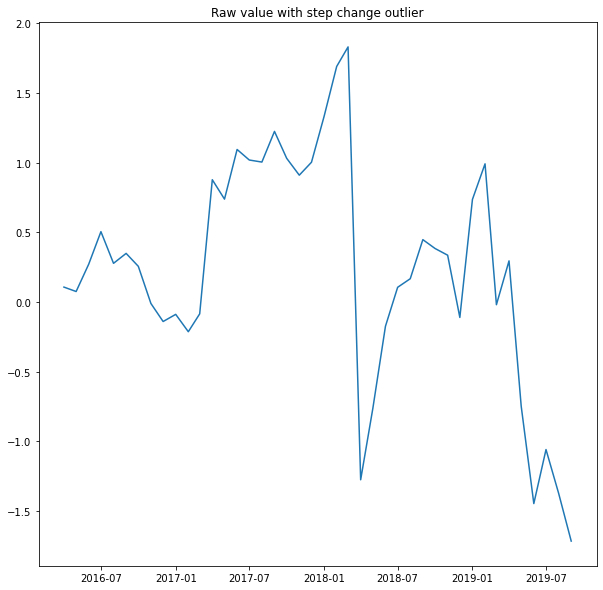

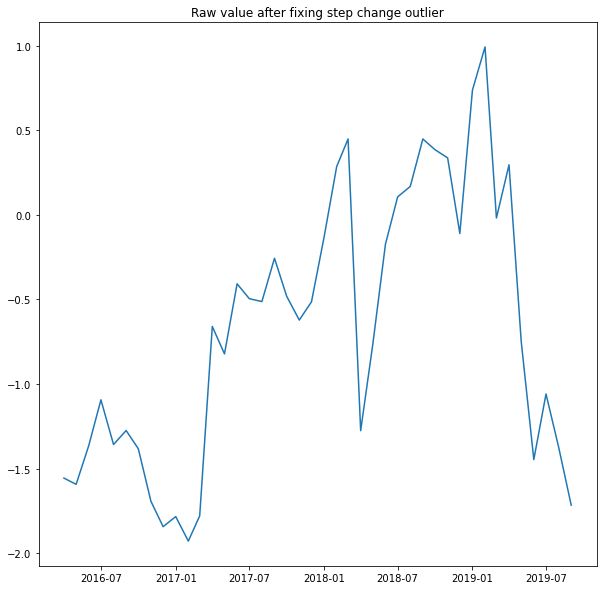

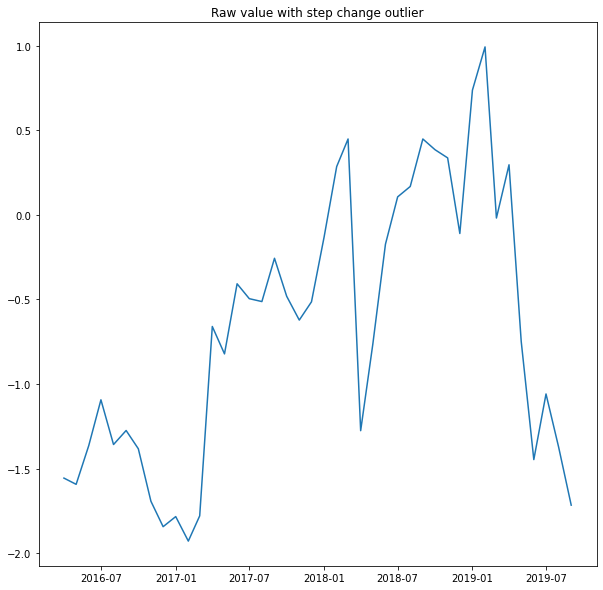

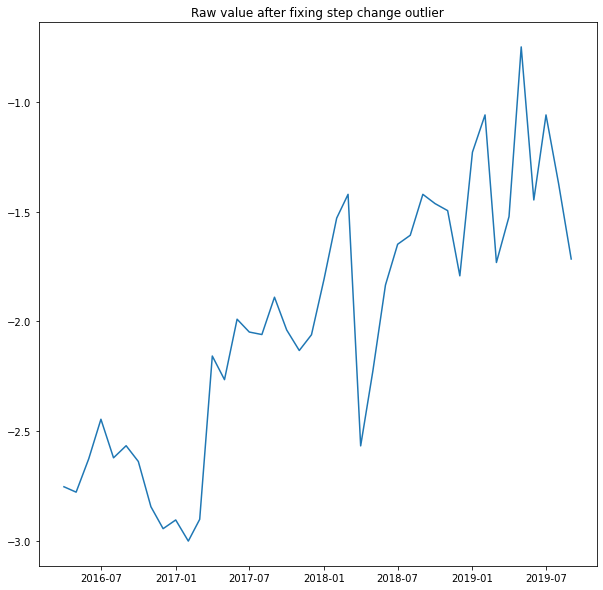

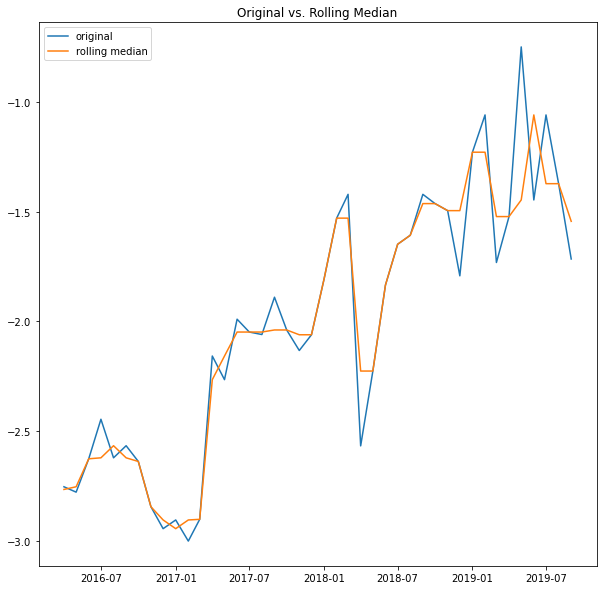

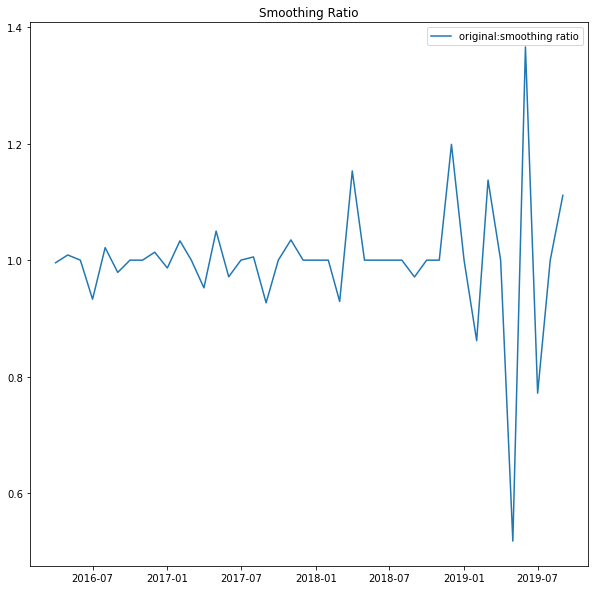

Outliers found at  DatetimeIndex(['2016-07-01', '2016-08-01', '2017-02-01', '2017-04-01',
               '2017-05-01', '2017-06-01', '2017-09-01', '2017-11-01',
               '2018-03-01', '2018-04-01', '2018-09-01', '2018-12-01',
               '2019-02-01', '2019-03-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-09-01'],
              dtype='datetime64[ns]', name='time', freq=None)


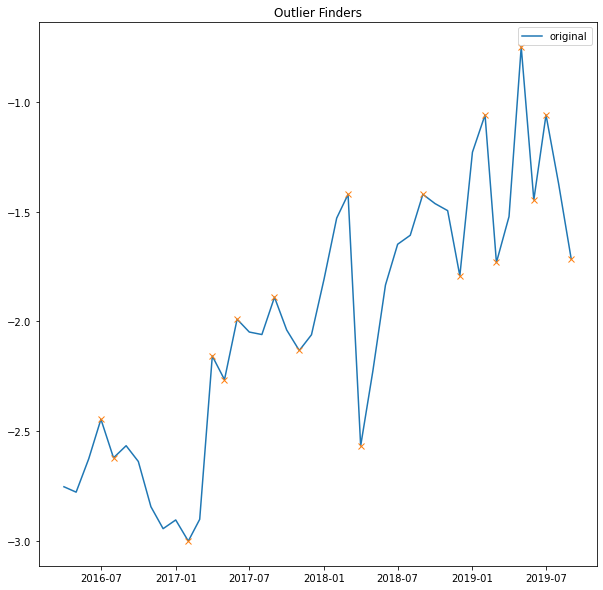

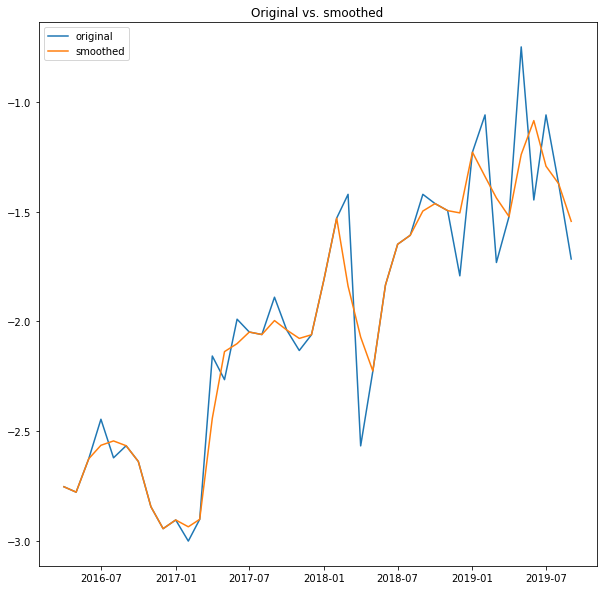

 25%|██▌       | 1/4 [00:01<00:05,  1.80s/it]

Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon


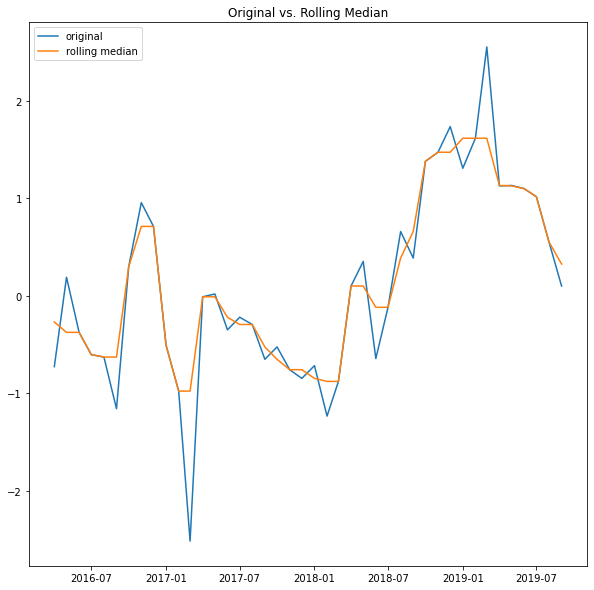

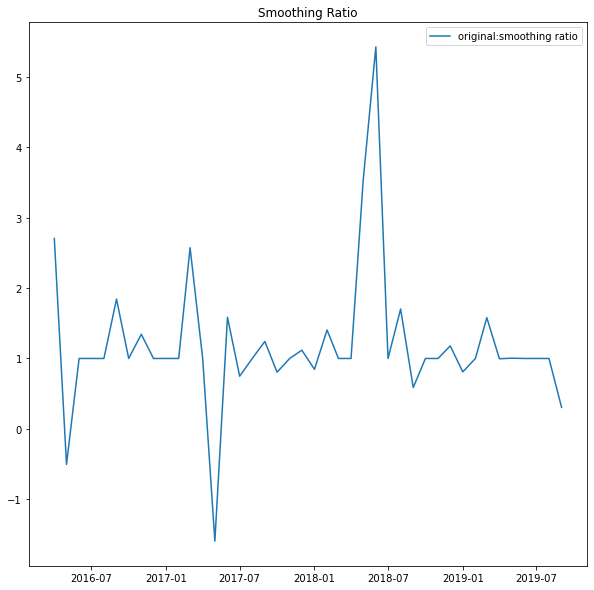

Outliers found at  DatetimeIndex(['2016-09-01', '2016-11-01', '2017-03-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-09-01', '2017-10-01',
               '2018-01-01', '2018-02-01', '2018-05-01', '2018-06-01',
               '2018-08-01', '2018-09-01', '2018-12-01', '2019-01-01',
               '2019-03-01', '2019-09-01'],
              dtype='datetime64[ns]', name='time', freq=None)


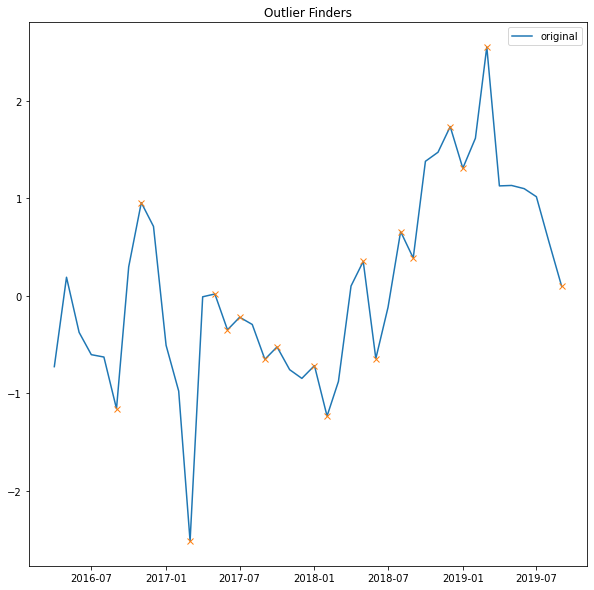

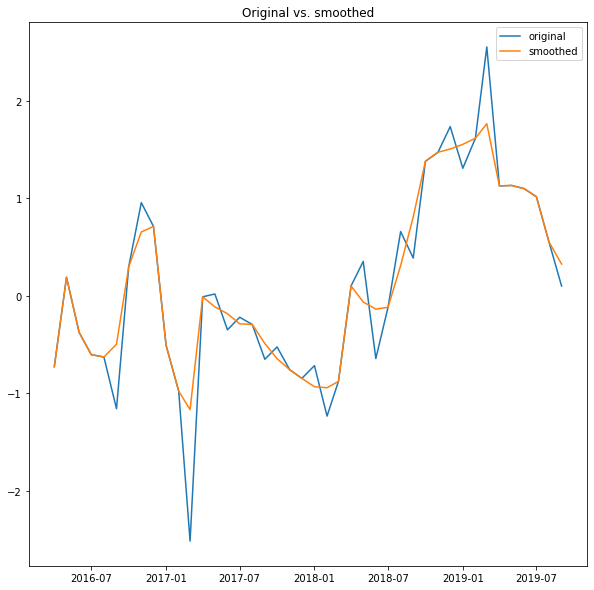

 50%|█████     | 2/4 [00:02<00:02,  1.47s/it]

Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)


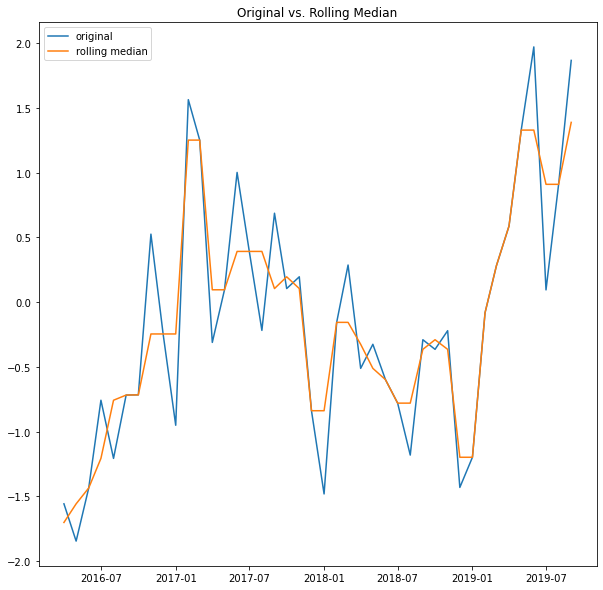

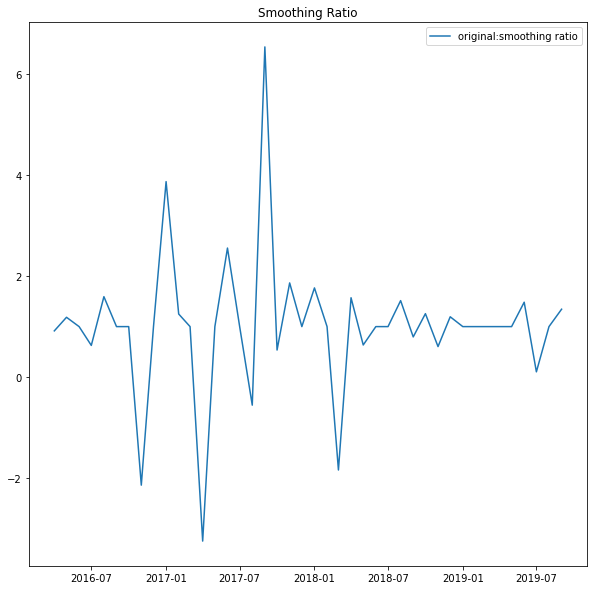

Outliers found at  DatetimeIndex(['2016-08-01', '2016-11-01', '2017-01-01', '2017-04-01',
               '2017-06-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2018-01-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-08-01', '2018-11-01', '2019-06-01',
               '2019-07-01', '2019-09-01'],
              dtype='datetime64[ns]', name='time', freq=None)


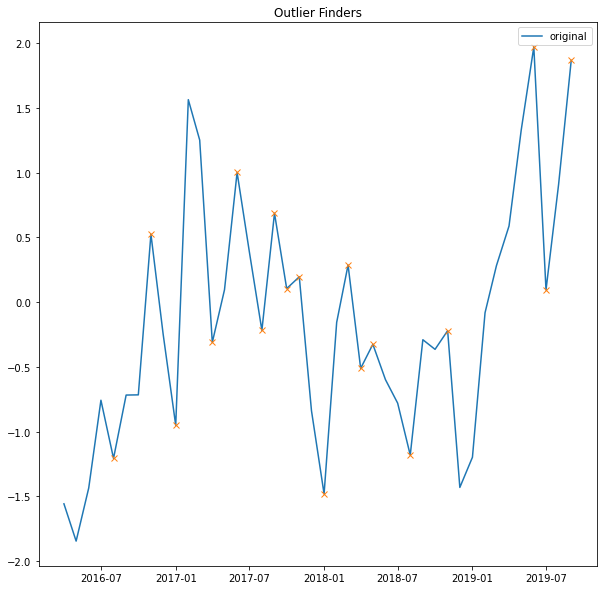

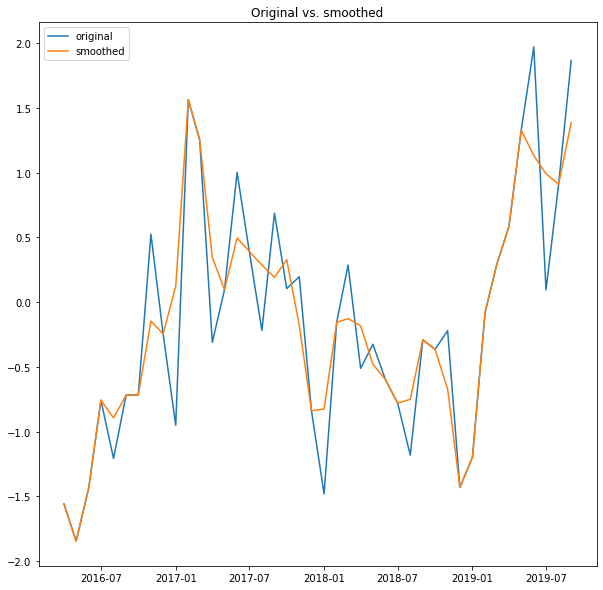

 75%|███████▌  | 3/4 [00:03<00:01,  1.25s/it]

Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)


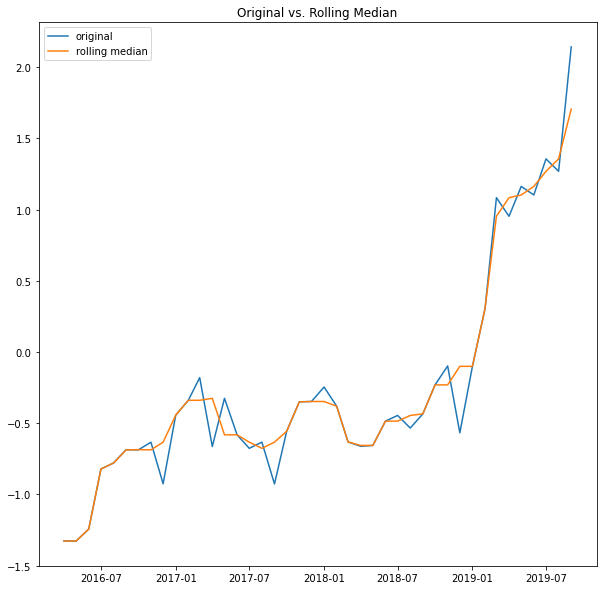

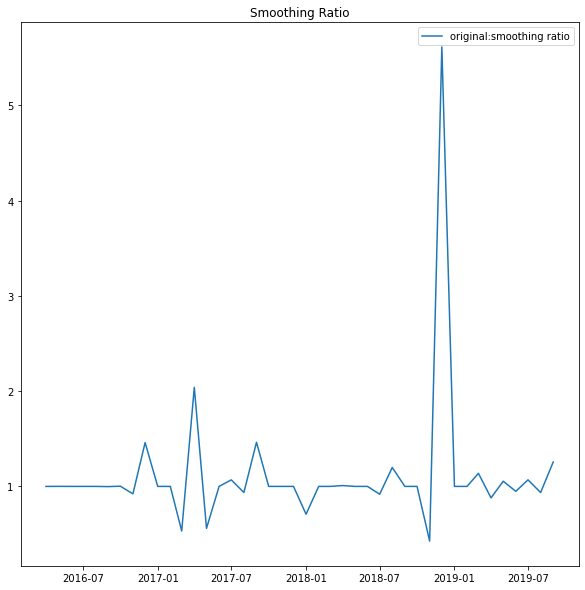

Outliers found at  DatetimeIndex(['2016-11-01', '2016-12-01', '2017-03-01', '2017-04-01',
               '2017-05-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2018-01-01', '2018-07-01', '2018-08-01', '2018-11-01',
               '2018-12-01', '2019-03-01', '2019-04-01', '2019-07-01',
               '2019-08-01', '2019-09-01'],
              dtype='datetime64[ns]', name='time', freq=None)


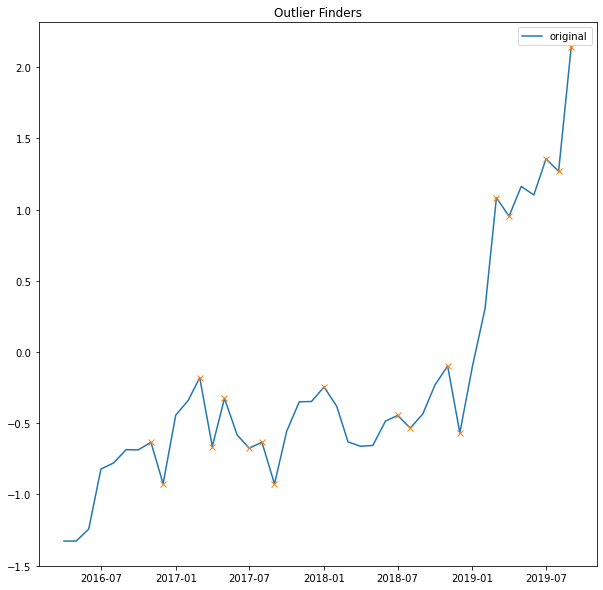

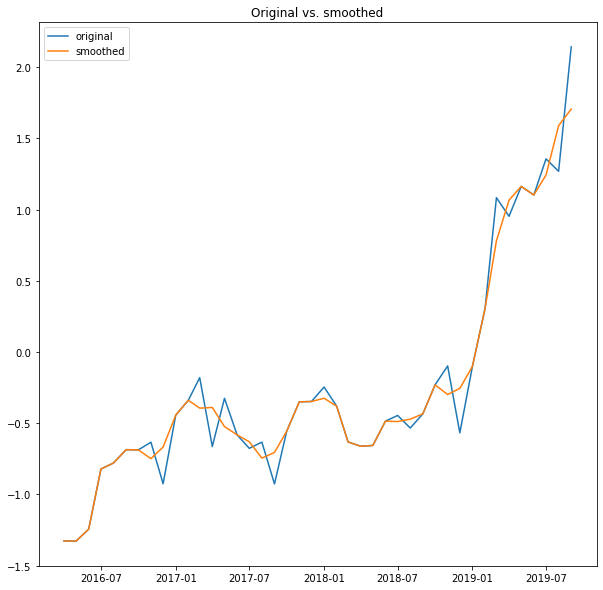

100%|██████████| 4/4 [00:04<00:00,  1.05s/it]


In [66]:
## Outlier smoothing done here
smoothed_data = []
for col in tqdm(cols_to_predict):
    print(col)
    temp_X = X[~X[col].isnull()]
    temp_X = temp_X['2016-04-01':'2019-09-01']
    temp_X[col] = pd.to_numeric(temp_X[col])
    temp_X_col = temp_X[col]
    if np.any(np.array(step_cols)==col):
        temp_X_col = utils.fix_step_change(temp_X_col,
                                           step_change_date='2018-03-01',
                                           post_step_change_start='2018-04-01',
                                           corrected_step_max = '2018-09-01')
        temp_X_col = utils.fix_step_change(temp_X_col,
                                           step_change_date='2019-04-01',
                                           post_step_change_start='2019-05-01',
                                           corrected_step_max = '2019-07-01')
    if np.any(np.array(excptn_2_smooth)==col): 
        temp_X_smoothed = temp_X_col.copy()
    else:
        temp_X_smoothed = utils.outlier_smoothing(temp_X_col, contamination=0.45)
    
    smoothed_data.append(temp_X_smoothed)

In [67]:
len(smoothed_data)

4

In [68]:
smoothed_data_df = pd.DataFrame(pd.concat(smoothed_data, axis=1).values, columns=cols_to_predict)

In [69]:
smoothed_data_df.set_index(X['2016-04-01':'2019-09-01'].index.values, inplace=True)

In [70]:
smoothed_data_df

Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon  \
2016-04-01                                          -2.754465                                                                
2016-05-01                                          -2.779012                                                                
2016-06-01                                          -2.626921                                                                
2016-07-01                                          -2.565329                                                                
2016-08-01                                          -2.545454                                                                
2016-09-01                                          -2.567295                                                                
2016-10-01                                          -2.639148                                                                
2016-11-01                                          -2.845569                                                                
2016-12-01                                          -2.945581                                                                
2017-01-01                                          -2.905860                                                                
2017-02-01                                          -2.937019                                                                
2017-03-01                                          -2.902974                                                                
2017-04-01                                          -2.442406                                                                
2017-05-01                                          -2.138198                                                                
2017-06-01                                          -2.101743                                                                
2017-07-01                                          -2.048866                                                                
2017-08-01                                          -2.060263                                                                
2017-09-01                                          -1.996566                                                                
2017-10-01                                          -2.039422                                                                
2017-11-01                                          -2.077920                                                                
2017-12-01                                          -2.061292                                                                
2018-01-01                                          -1.806908                                                                
2018-02-01                                          -1.529446                                                                
2018-03-01                                          -1.839439                                                                
2018-04-01                                          -2.071873                                                                
2018-05-01                                          -2.226748                                                                
2018-06-01                                          -1.834659                                                                
2018-07-01                                          -1.648538                                                                
2018-08-01                                          -1.607585                                                                
2018-09-01                                          -1.497186                                                                
2018-10-01                                          -1.463114                                             

In [71]:
sarimax_scores_params = {}

In [72]:
sarimax_scores_params

{}

In [73]:
df_sarimax_val_true = pd.DataFrame({})
df_sarimax_val_pred = pd.DataFrame({})
df_sarimax_test_pred = pd.DataFrame({})

In [74]:
## Change the date values accordingly for different prediction date range
df_sarimax_test_pred['Date'] = \
[datetime.date(datetime.strptime('2019-09-01',"%Y-%m-%d")) + \
 relativedelta.relativedelta(months=i) for i in range(1, predict_horizon+1)]

In [75]:
## SARIMAX prediction
for col in tqdm(predict_targets):
    X_sarimax = smoothed_data_df[col]['2016-04-01':].copy()
    X_sarimax = pd.DataFrame(X_sarimax)
#     print(pd.DataFrame(X_sarimax).iloc[:-5,0])
#     pd.concat([smoothed_data_df[col]['2014-04-01':],
#                price_increase_df['2014-04-01':]], axis=1)
    best_score, best_mape, val_prediction, best_params, best_param_seasonal = \
    model.validate_sarimax(X_sarimax, steps=VSTEPS)
    
    sarimax_scores_params[col] = {
            "raw_score": best_score,
            "mape_score": best_mape,
            "params": best_params,
            "seasonal_params": best_param_seasonal
        }
    
    test_predictions = model.fit_and_predict_sarimax(X_sarimax,
#                                                      exog_forecast=\
#                                                      forecast_price_increase_df,
                                                     params=best_params,
                                                     seasonal_params=best_param_seasonal,
                                                     predict_horizon=predict_horizon
                                                    )
    df_sarimax_test_pred[col] = test_predictions.values
    df_sarimax_val_pred[col] = val_prediction
    df_sarimax_val_true[col] = X_sarimax.iloc[-VSTEPS:,0]

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:45<02:15, 45.01s/it]

 50%|█████     | 2/4 [01:23<01:26, 43.17s/it]

 75%|███████▌  | 3/4 [02:00<00:41, 41.11s/it]

100%|██████████| 4/4 [02:42<00:00, 40.75s/it]

In [76]:
sarimax_scores_params

{'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon': {'raw_score': 0.9199301327313062,
  'mape_score': 8.006992777607731,
  'params': (1, 0, 0),
  'seasonal_params': (0, 1, 0, 3)},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon': {'raw_score': 0.733168545263707,
  'mape_score': 26.683108286036333,
  'params': (1, 1, 0),
  'seasonal_params': (1, 0, 1, 12)},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)': {'raw_score': 0.5378729114793289,
  'mape_score': 66.92254576421958,
  'params': (1, 1, 0),
  'seasonal_params': (0, 1, 0, 3)},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)': {'raw_score': 0.31986034281707015,
  'mape_score': 70.73678602159794,
  'params': (1, 1, 1),
  'seasonal_params': (0, 1, 0, 6)}}

In [77]:
json.dumps(sarimax_scores_params)

'{"Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon": {"raw_score": 0.9199301327313062, "mape_score": 8.006992777607731, "params": [1, 0, 0], "seasonal_params": [0, 1, 0, 3]}, "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon": {"raw_score": 0.733168545263707, "mape_score": 26.683108286036333, "params": [1, 1, 0], "seasonal_params": [1, 0, 1, 12]}, "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)": {"raw_score": 0.5378729114793289, "mape_score": 66.92254576421958, "params": [1, 1, 0], "seasonal_params": [0, 1, 0, 3]}, "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)": {"raw_score": 0.31986034281707015, "mape_score": 70.73678602159794, "params": [1, 1, 1], "seasonal_params": [0, 1, 0, 6]}}'

In [79]:
import json

In [80]:
json.dumps(sarimax_scores_params)

'{"Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon": {"raw_score": 0.9199301327313062, "mape_score": 8.006992777607731, "params": [1, 0, 0], "seasonal_params": [0, 1, 0, 3]}, "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon": {"raw_score": 0.733168545263707, "mape_score": 26.683108286036333, "params": [1, 1, 0], "seasonal_params": [1, 0, 1, 12]}, "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)": {"raw_score": 0.5378729114793289, "mape_score": 66.92254576421958, "params": [1, 1, 0], "seasonal_params": [0, 1, 0, 3]}, "Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)": {"raw_score": 0.31986034281707015, "mape_score": 70.73678602159794, "params": [1, 1, 1], "seasonal_params": [0, 1, 0, 6]}}'

In [81]:
scores_and_params

{'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon': {'raw_score': 0.8968476466789556,
  'mape_score': 10.315242915446298,
  'params': {'train_points': 12,
   'scale': 'MinMax',
   'model': 'lr',
   'diff': False}},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon': {'raw_score': 0.7418264177694942,
  'mape_score': 49.47927439850277,
  'params': {'train_points': 12,
   'scale': 'MinMax',
   'model': 'xgboost',
   'diff': False}},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)': {'raw_score': 0.7260264881650138,
  'mape_score': 27.397322775908584,
  'params': {'train_points': 12,
   'scale': 'MinMax',
   'model': 'xgboost',
   'diff': True}},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)': {'raw_score': 0.9335981260576912,
  'mape_score': 6.64018233879428

In [82]:
regression_score_df = \
pd.DataFrame(scores_and_params).T.reset_index().iloc[:,:3].\
rename(columns={"index":"cols",
                "raw_score":"regression_raw",
                "mape_score":"regression_mape"
               })

In [83]:
sarimax_score_df = \
pd.DataFrame(sarimax_scores_params).T.reset_index().iloc[:,:3].\
rename(columns={"index":"cols",
                "raw_score":"sarimax_raw",
                "mape_score":"sarimax_mape"
               })

In [84]:
all_score_df = pd.merge(regression_score_df, sarimax_score_df)

In [85]:
all_score_df

cols regression_raw  \
0  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...       0.896848   
1  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...       0.741826   
2  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...       0.726026   
3  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...       0.933598   

  regression_mape sarimax_raw sarimax_mape  
0         10.3152     0.91993      8.00699  
1         49.4793    0.733169      26.6831  
2         27.3973    0.537873      66.9225  
3         6.64018     0.31986      70.7368

In [86]:
all_score_df.dtypes

cols               object
regression_raw     object
regression_mape    object
sarimax_raw        object
sarimax_mape       object
dtype: object

## LSTM

In [87]:
VSTEPS = 12

  0%|          | 0/4 [00:00<?, ?it/s]

Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon


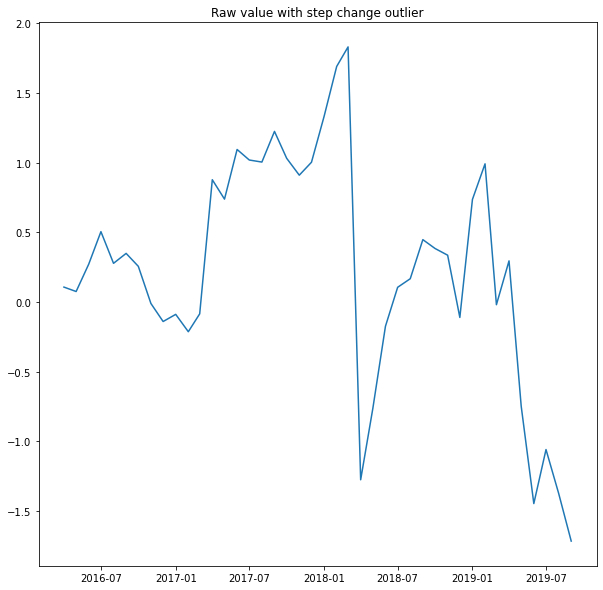

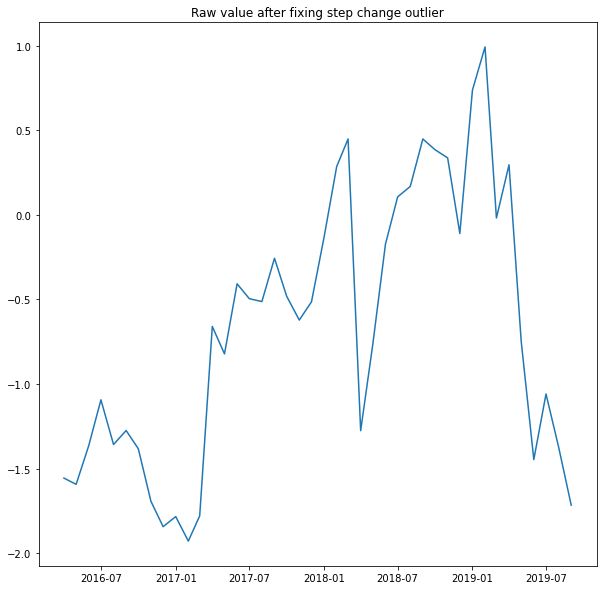

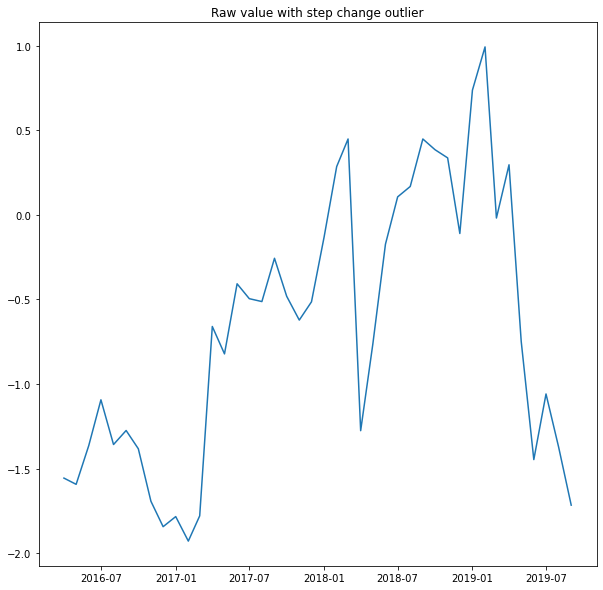

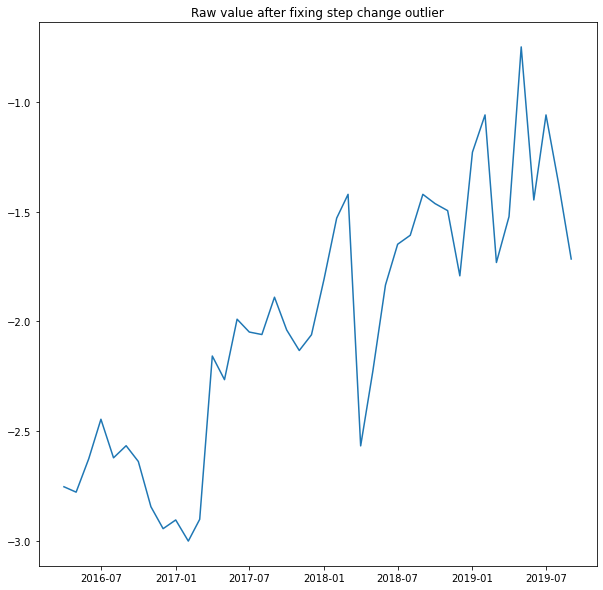

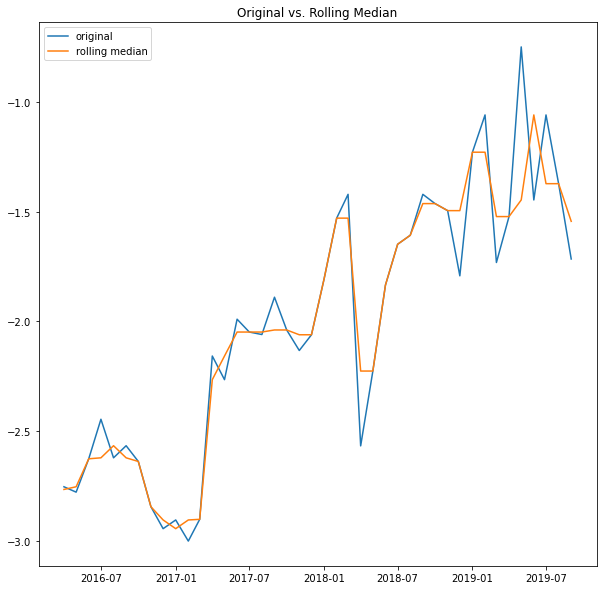

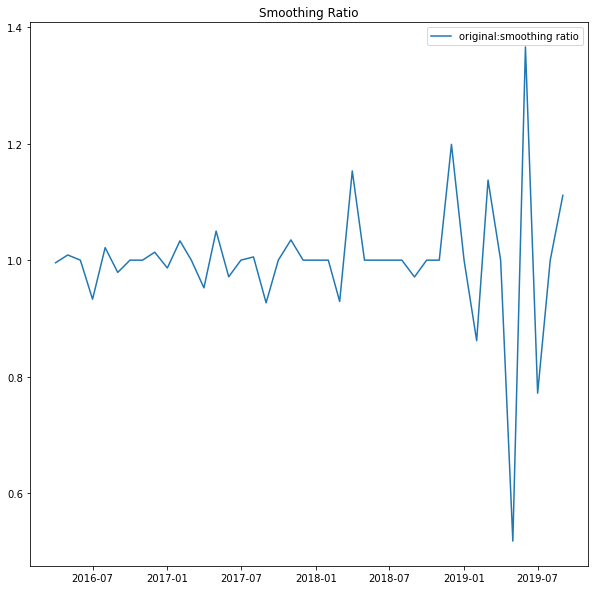

Outliers found at  DatetimeIndex(['2016-07-01', '2017-05-01', '2017-09-01', '2018-03-01',
               '2018-04-01', '2018-12-01', '2019-02-01', '2019-03-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-09-01'],
              dtype='datetime64[ns]', name='time', freq=None)


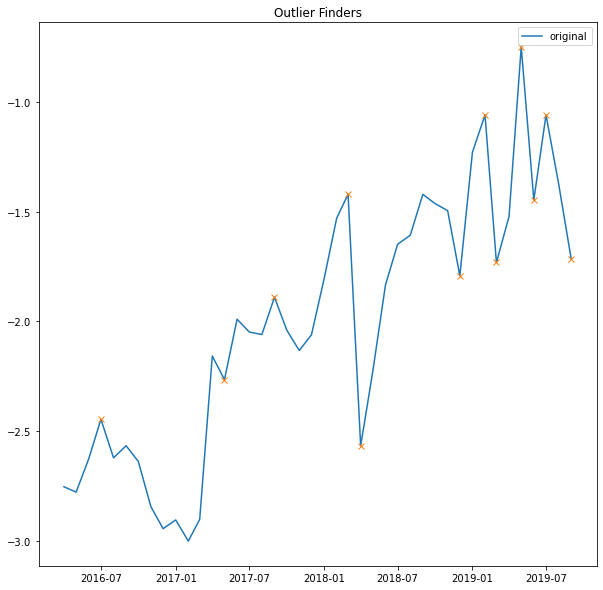

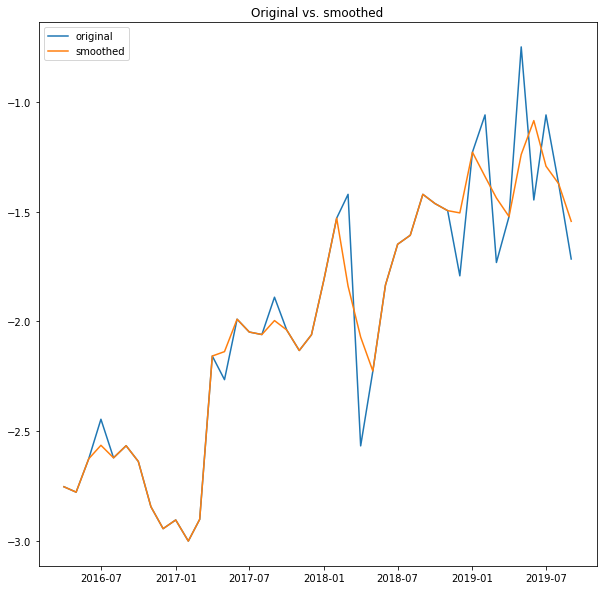

 25%|██▌       | 1/4 [00:01<00:03,  1.28s/it]

Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon


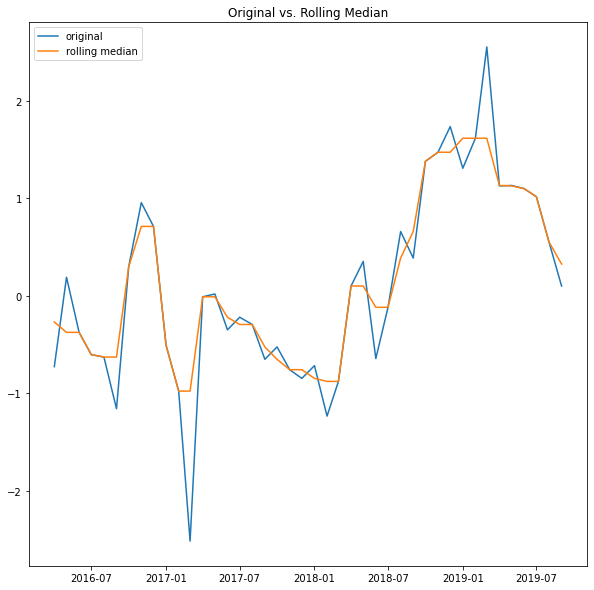

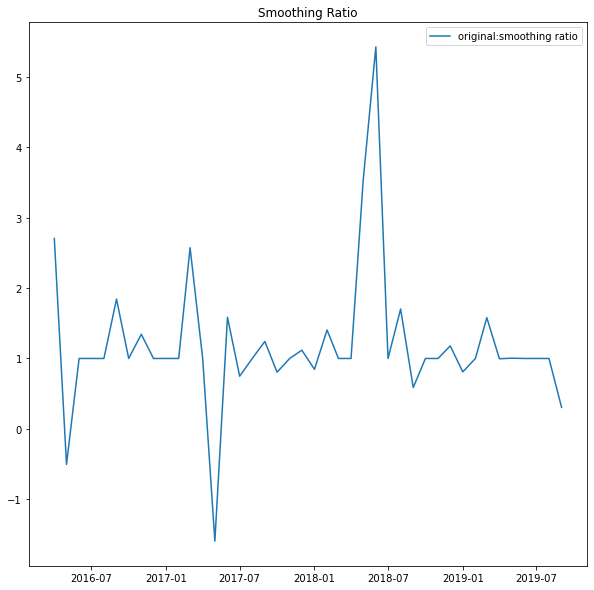

Outliers found at  DatetimeIndex(['2016-09-01', '2017-03-01', '2017-05-01', '2017-06-01',
               '2017-07-01', '2018-02-01', '2018-05-01', '2018-06-01',
               '2018-08-01', '2018-09-01', '2019-03-01', '2019-09-01'],
              dtype='datetime64[ns]', name='time', freq=None)


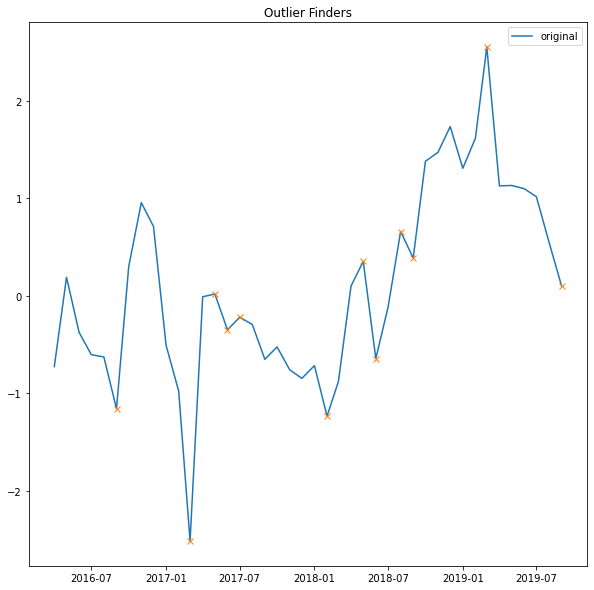

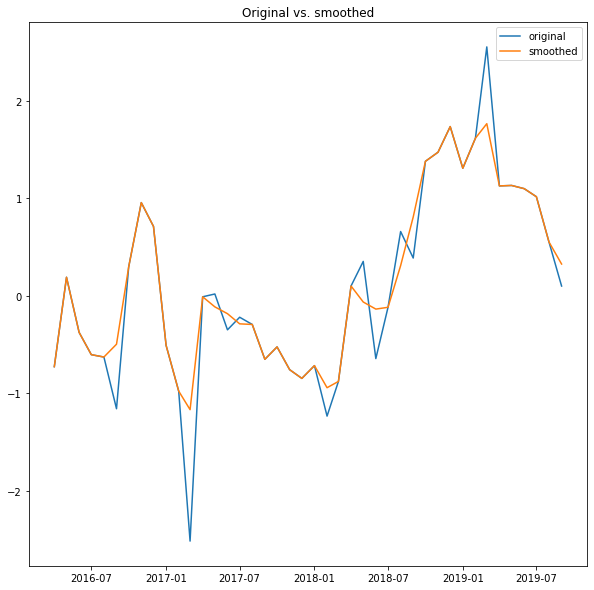

 50%|█████     | 2/4 [00:01<00:02,  1.10s/it]

Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)


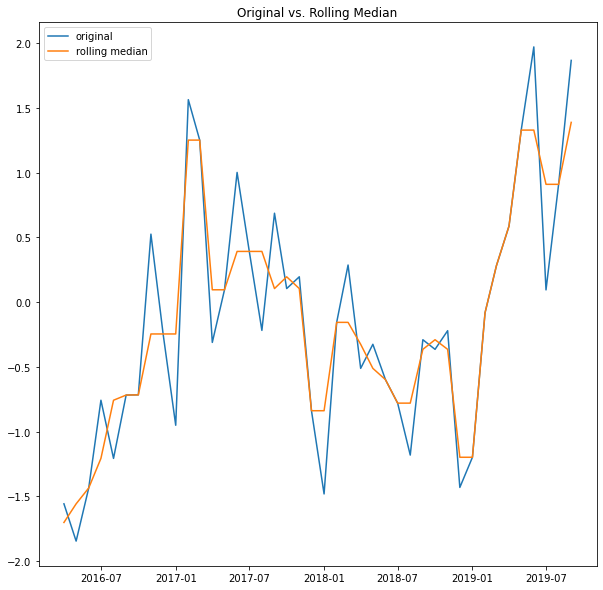

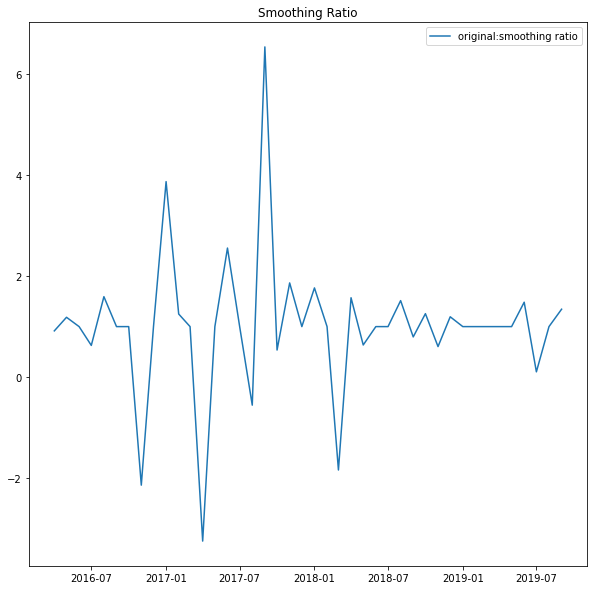

Outliers found at  DatetimeIndex(['2016-08-01', '2016-11-01', '2017-01-01', '2017-04-01',
               '2017-06-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2018-01-01', '2018-03-01', '2019-07-01'],
              dtype='datetime64[ns]', name='time', freq=None)


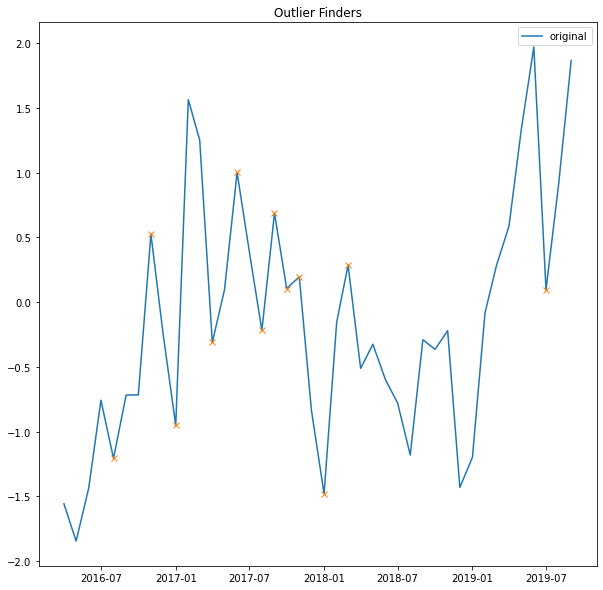

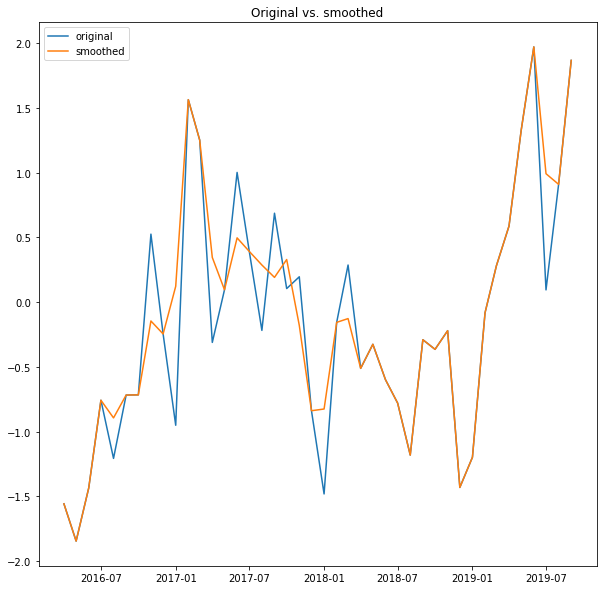

 75%|███████▌  | 3/4 [00:02<00:00,  1.02it/s]

Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)


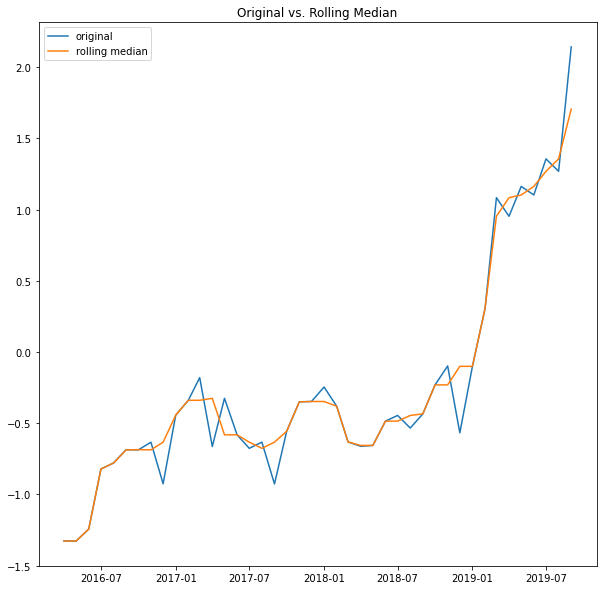

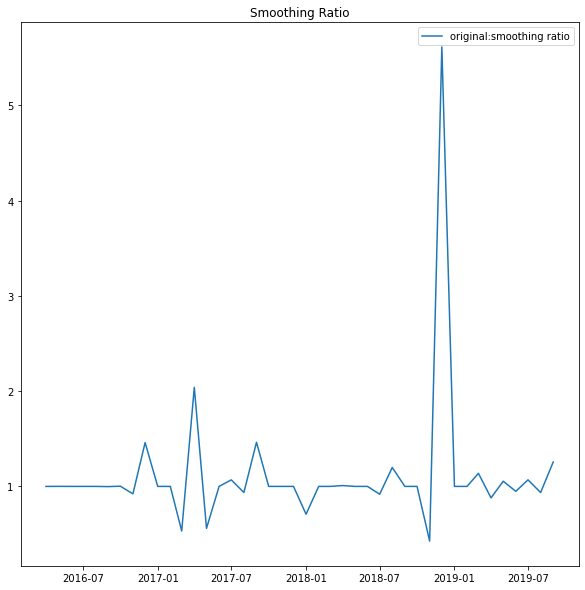

Outliers found at  DatetimeIndex(['2016-12-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-09-01', '2018-01-01', '2018-08-01', '2018-11-01',
               '2018-12-01', '2019-03-01', '2019-04-01', '2019-09-01'],
              dtype='datetime64[ns]', name='time', freq=None)


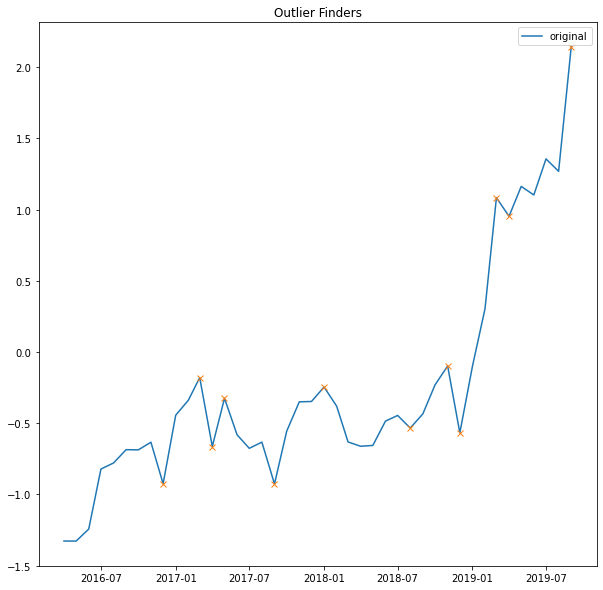

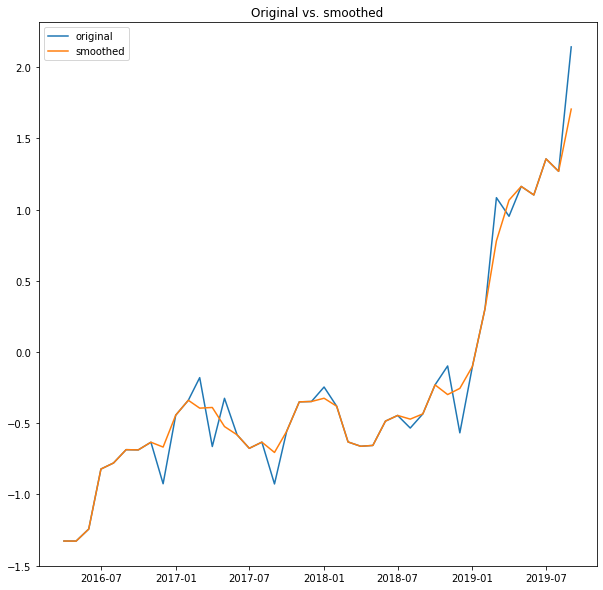

100%|██████████| 4/4 [00:03<00:00,  1.20it/s]


In [88]:
## Outlier smoothing done here
smoothed_data = []
for col in tqdm(cols_to_predict):
    print(col)
    temp_X = X[~X[col].isnull()]
    temp_X = temp_X['2016-04-01':'2019-09-01']
    temp_X[col] = pd.to_numeric(temp_X[col])
    temp_X_col = temp_X[col]
    if np.any(np.array(step_cols)==col):
        temp_X_col = utils.fix_step_change(temp_X_col,
                                           step_change_date='2018-03-01',
                                           post_step_change_start='2018-04-01',
                                           corrected_step_max = '2018-09-01')
        temp_X_col = utils.fix_step_change(temp_X_col,
                                           step_change_date='2019-04-01',
                                           post_step_change_start='2019-05-01',
                                           corrected_step_max = '2019-07-01')
    if np.any(np.array(excptn_2_smooth)==col): 
        temp_X_smoothed = temp_X_col.copy()
    else:
        temp_X_smoothed = utils.outlier_smoothing(temp_X_col, contamination=0.3)
    
    smoothed_data.append(temp_X_smoothed)

In [89]:
smoothed_data_df = pd.DataFrame(pd.concat(smoothed_data, axis=1).values, columns=cols_to_predict)

smoothed_data_df.set_index(X['2016-04-01':'2019-09-01'].index.values, inplace=True)

In [90]:
def create_step_dataset(data, n_input, n_out):
    X, y = [], []

    in_start = 0
    
    data = pd.DataFrame(data)
    
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance 
        if out_end < len(data):
            X.append(data.iloc[in_start:in_end, :].values)
            y.append(data.iloc[in_end:out_end, 0].values)
            
        in_start += 1
    return np.array(X), np.array(y)

In [91]:
for col in tqdm(predict_targets):
    print(col)

100%|██████████| 4/4 [00:00<00:00, 4321.80it/s]

Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon
Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon
Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)
Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)


In [92]:
## Function for Model training

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation, Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import RepeatVector 
from keras.layers import TimeDistributed 
from keras.layers import ConvLSTM2D
def train_LSTM_model(X, y, 
                     look_back, 
                     layer_1=64,
                     layer_2=32,
                     layer_3=16,
                     layer_4=8,
                     num_layers=4,
                     epochs=270, 
                     batch_size=6, 
                     verbose=10):
    lstm_model = Sequential()
    if num_layers==4:
        lstm_model.add(LSTM(layer_1, return_sequences= True, activation='relu', input_shape=( 1,look_back)))
        lstm_model.add(Dropout(0.15))
        lstm_model.add(LSTM(units=layer_2, activation='relu', return_sequences=True))
        lstm_model.add(Dropout(0.1))
        lstm_model.add(LSTM(units=layer_3, activation='relu', return_sequences=True))
        lstm_model.add(Dropout(0.05))
        lstm_model.add(LSTM(units=layer_4, activation='relu'))
    elif num_layers==3:
        lstm_model.add(LSTM(layer_1, return_sequences= True, activation='relu', input_shape=( 1,look_back)))
        lstm_model.add(Dropout(0.1))
        lstm_model.add(LSTM(units=layer_2, activation='relu', return_sequences=True))
        lstm_model.add(Dropout(0.05))
        lstm_model.add(LSTM(units=layer_3, activation='relu'))
    elif num_layers==2:
        lstm_model.add(LSTM(layer_1, return_sequences= True, activation='relu', input_shape=( 1,look_back)))
        lstm_model.add(Dropout(0.05))
        lstm_model.add(LSTM(units=layer_2, activation='relu'))
    lstm_model.add(Dense(1))
    lstm_model.compile(loss='mean_squared_error', optimizer='adam')
    lstm_model.fit(X, y, \
        epochs=epochs, 
        batch_size=batch_size, 
        verbose=verbose)
    return lstm_model

In [93]:
import numpy as np

In [94]:
## Function for LSTM validation
def validate_lstm(X_lstm, steps=VSTEPS, lookback=3):
    train_length = X_lstm.shape[0]-VSTEPS
    print(train_length)
    lstm_train_X, lstm_train_y = create_step_dataset(X_lstm[:train_length], lookback, 1)
#     print(lstm_train_X.shape)
    lstm_train_X =\
    np.reshape(lstm_train_X, 
               (lstm_train_X.shape[0], 
                lstm_train_X.shape[2], 
                lstm_train_X.shape[1]))
    num_dims = lstm_train_X.shape[2]
    lstm_val_X, lstm_val_y = create_step_dataset(X_lstm[(train_length-lookback-1):], 
                                                 lookback, 1)
#     print(lstm_val_X.shape)
    lstm_val_X =\
    np.reshape(lstm_val_X, 
               (lstm_val_X.shape[0], 
                lstm_val_X.shape[2], 
                lstm_val_X.shape[1]))
    
#     print(lstm_train_X.shape, lstm_val_X.shape)
    epochs = [150]#np.arange(50,200,50)
    batches = [4] #np.arange(2,8,2)
    layers = [2,3,4]
    unit_configs = [(128,64,32,16),
                    (64,32,16,8),
                    (32,16,8,4)
                   ]
    min_mape_score = 9999
    min_score = -99
    result_params = {}
    try:
        for e in epochs:
            for b in batches:
                for l in layers:
                    for u in unit_configs:
                        lstm_model = train_LSTM_model(lstm_train_X, 
                                                      lstm_train_y, 
                                                      look_back=lookback,
                                                      layer_1=u[0],
                                                      layer_2=u[1],
                                                      layer_3=u[2],
                                                      layer_4=u[3],
                                                      num_layers=l,
                                                      epochs=e,
                                                      batch_size=b,
                                                      verbose=False
                                                     )
                        mape_error = scoring(lstm_val_y, lstm_model.predict(lstm_val_X))
                        raw_error = raw_scoring(lstm_val_y, lstm_model.predict(lstm_val_X))
                        print(lstm_val_y)
                        print(lstm_model.predict(lstm_val_X))
                        print(lstm_model.predict(lstm_val_X).shape, lstm_val_y.shape)
                        print(raw_error)
                        print(min_score)
                        print(mape_error)
                        print(min_mape_score)
                        
    #                     print(f"orig: {lstm_val_y} and predict: {np.nan_to_num(lstm_model.predict(lstm_val_X))}")
    #                     print(f'RMSE {rmse_error} and min RMSE is {min_rmse_score}')
    #                     print(f'MAPE {mape_error} and min MAPE is {min_mape_score}')
#                         or mape_error < min_mape_score
                        if raw_error > min_score :
                            print("I am inside")
                            min_mape_score = mape_error
                            min_score = raw_error
                            final_prediction = lstm_model.predict(lstm_val_X)
                            result_params["epochs"] = e
                            result_params["batch_size"] = b
                            result_params["num_layers"] = l
                            result_params["unit_config"] = u
    except Exception as e:
        print(e)

    return min_mape_score, min_score, final_prediction, result_params

In [95]:
df_lstm_val_true = pd.DataFrame({})
df_lstm_val_pred = pd.DataFrame({})
df_lstm_test_pred = pd.DataFrame({})

In [96]:
## Change the date values accordingly for different prediction date range
df_lstm_test_pred['Date'] = \
[datetime.date(datetime.strptime('2019-09-01',"%Y-%m-%d")) + \
 relativedelta.relativedelta(months=i) for i in range(1, predict_horizon+1)]

In [97]:
df_lstm_test_pred

Date
0   2019-10-01
1   2019-11-01
2   2019-12-01
3   2020-01-01
4   2020-02-01
5   2020-03-01
6   2020-04-01
7   2020-05-01
8   2020-06-01
9   2020-07-01
10  2020-08-01
11  2020-09-01

In [98]:
predict_horizon

12

In [99]:
[predict_targets[2]]

['Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)']

In [100]:
## Validate , Re-train and Predict for target horizon
lstm_scores_params = {}
lookback = 12
for col in tqdm(predict_targets):
    print(col)
    X_lstm = smoothed_data_df[col]['2016-04-01':].copy()
#     pd.concat([smoothed_data_df[col]['2017-04-01':],
#                price_increase_df['2017-04-01':]], axis=1)
    best_mape_score, best_score, final_prediction, best_params = \
    validate_lstm(X_lstm, lookback=lookback)
    lstm_scores_params[col] = {
            "raw_score": best_score,
            "mape_score": best_mape_score,
            "params": best_params
        }
    
    ## create X and y in lstm input format for the specified column
    lstm_X, lstm_y = create_step_dataset(X_lstm, lookback, 1)
    
    lstm_X =\
    np.reshape(lstm_X, 
               (lstm_X.shape[0], 
                1, 
                lstm_X.shape[1]))
    
    ## Re-Train the model with best params
    lstm_model = train_LSTM_model(lstm_X, 
                                  lstm_y, 
                                  look_back=lookback,
                                  layer_1=best_params["unit_config"][0],
                                  layer_2=best_params["unit_config"][1],
                                  layer_3=best_params["unit_config"][2],
                                  layer_4=best_params["unit_config"][3],
                                  num_layers=best_params["num_layers"],
                                  epochs=best_params["epochs"],
                                  batch_size=best_params["batch_size"]
                                 )
    
    ## Prediction of future using retrained model
    lstm_prediction = []
    index = len(X_lstm)
    forecast_price_index = 0
    prediction_y = np.array([-99])
    for _ in range(predict_horizon):
        
        if prediction_y.reshape(1)[0] == -99:
            prediction_x = \
            X_lstm.iloc[index-lookback:].values
        if prediction_y.reshape(1)[0] != -99:
#             new_pred_row = np.hstack([prediction_y.reshape(1)[0],
#                                       forecast_price_increase_df.\
#                                       iloc[forecast_price_index].values])
            new_pred_row = prediction_y.reshape(1)[0]

            prediction_x = np.hstack([prediction_x.reshape(-1)[1:], new_pred_row])
        
        prediction_x = \
        prediction_x.reshape(-1,1,lookback)

        prediction_y = lstm_model.predict(prediction_x)
        lstm_prediction.append(prediction_y.reshape(1)[0])
        index += 1
        forecast_price_index += 1
        
    df_lstm_val_pred[col] = final_prediction.reshape(-1)
    df_lstm_test_pred[col] = lstm_prediction

  0%|          | 0/4 [00:00<?, ?it/s]

Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon
30
[[-1.4208579 ]
 [-1.46311432]
 [-1.49521943]
 [-1.50549012]
 [-1.2287233 ]
 [-1.33972853]
 [-1.43759406]
 [-1.52231991]
 [-1.23913636]
 [-1.0846161 ]
 [-1.29251612]
 [-1.37226552]]
[[-1.7617288]
 [-1.7212465]
 [-1.7050153]
 [-1.7318562]
 [-1.7337912]
 [-1.6206906]
 [-1.5891588]
 [-1.5958211]
 [-1.5914801]
 [-1.4812131]
 [-1.4296814]
 [-1.4807582]]
(12, 1) (12, 1)
0.8069443388207836
-99
19.305580997828912
9999
I am inside
[[-1.4208579 ]
 [-1.46311432]
 [-1.49521943]
 [-1.50549012]
 [-1.2287233 ]
 [-1.33972853]
 [-1.43759406]
 [-1.52231991]
 [-1.23913636]
 [-1.0846161 ]
 [-1.29251612]
 [-1.37226552]]
[[-1.7450022]
 [-1.7002523]
 [-1.6677086]
 [-1.6568737]
 [-1.64508  ]
 [-1.5915368]
 [-1.5659556]
 [-1.5528822]
 [-1.522356 ]
 [-1.4382595]
 [-1.3727405]
 [-1.3823421]]
(12, 1) (12, 1)
0.8444728590043953
0.8069443388207836
15.552726141986408
19.305580997828912
I am inside
[[-1.42

 25%|██▌       | 1/4 [00:57<02:53, 57.82s/it]

Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon
30
[[0.80851513]
 [1.3798174 ]
 [1.47297917]
 [1.73627489]
 [1.30873001]
 [1.61666059]
 [1.7661222 ]
 [1.12739901]
 [1.13187685]
 [1.09911232]
 [1.01634595]
 [0.55121912]]
[[0.13029376]
 [0.06786549]
 [0.02342407]
 [0.09320164]
 [0.1066795 ]
 [0.11113827]
 [0.06492394]
 [0.05110241]
 [0.04102032]
 [0.04816499]
 [0.04125468]
 [0.03328238]]
(12, 1) (12, 1)
0.05777492711743588
-99
94.222424123335
9999
I am inside
[[0.80851513]
 [1.3798174 ]
 [1.47297917]
 [1.73627489]
 [1.30873001]
 [1.61666059]
 [1.7661222 ]
 [1.12739901]
 [1.13187685]
 [1.09911232]
 [1.01634595]
 [0.55121912]]
[[ 0.23972201]
 [ 0.2170766 ]
 [ 0.2021083 ]
 [ 0.23740435]
 [ 0.25638545]
 [ 0.23653412]
 [ 0.18478921]
 [ 0.13240188]
 [ 0.05082306]
 [ 0.03363872]
 [ 0.00212305]
 [-0.03053998]]
(12, 1) (12, 1)
[0.11413684]
0.05777492711743588
89.04793942559634
94.222424123335
I am inside
[[0.80851513]
 [1.3798174

 50%|█████     | 2/4 [01:57<01:56, 58.24s/it]

Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)
30
[[-0.28994035]
 [-0.36428928]
 [-0.22019704]
 [-1.4306365 ]
 [-1.19771439]
 [-0.0816707 ]
 [ 0.28152776]
 [ 0.58820136]
 [ 1.32890251]
 [ 1.97128079]
 [ 0.99205445]
 [ 0.91005971]]
[[-0.72191906]
 [-0.27628338]
 [-0.36660317]
 [-0.5354976 ]
 [-0.7018365 ]
 [-0.9710546 ]
 [-0.9521243 ]
 [-0.46848628]
 [-0.1815829 ]
 [ 0.18821633]
 [-0.04962147]
 [-0.08701441]]
(12, 1) (12, 1)
[0.17910808]
-99
205.76106129162685
9999
I am inside
[[-0.28994035]
 [-0.36428928]
 [-0.22019704]
 [-1.4306365 ]
 [-1.19771439]
 [-0.0816707 ]
 [ 0.28152776]
 [ 0.58820136]
 [ 1.32890251]
 [ 1.97128079]
 [ 0.99205445]
 [ 0.91005971]]
[[-0.8098477 ]
 [-0.42876685]
 [-0.45924544]
 [-0.61188924]
 [-0.7933063 ]
 [-1.2349552 ]
 [-0.9449155 ]
 [-0.60437435]
 [-0.24411239]
 [ 0.08564851]
 [ 0.03809201]
 [ 0.02049185]]
(12, 1) (12, 1)
[0.16811843]
[0.17910808]
237.91862531574188
205.76106129162685
[[-0.28994035]
 [-0.36428928]

 75%|███████▌  | 3/4 [02:54<00:58, 58.12s/it]

Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)
30
[[-0.4350984 ]
 [-0.23141501]
 [-0.29938663]
 [-0.25598817]
 [-0.10121965]
 [ 0.3044112 ]
 [ 0.78005822]
 [ 1.06606366]
 [ 1.16242751]
 [ 1.10236405]
 [ 1.35581101]
 [ 1.26843546]]
[[-0.38011894]
 [-0.43859854]
 [-0.43696114]
 [-0.48003292]
 [-0.47666094]
 [-0.4094521 ]
 [-0.25834954]
 [-0.165375  ]
 [-0.13667628]
 [-0.13895361]
 [-0.14507979]
 [-0.13136914]]
(12, 1) (12, 1)
[0.13696771]
-99
127.92647838871044
9999
I am inside
[[-0.4350984 ]
 [-0.23141501]
 [-0.29938663]
 [-0.25598817]
 [-0.10121965]
 [ 0.3044112 ]
 [ 0.78005822]
 [ 1.06606366]
 [ 1.16242751]
 [ 1.10236405]
 [ 1.35581101]
 [ 1.26843546]]
[[-0.38399577]
 [-0.44996524]
 [-0.43366027]
 [-0.47226697]
 [-0.47234815]
 [-0.40733647]
 [-0.24214213]
 [-0.11171219]
 [-0.0811212 ]
 [-0.10733958]
 [-0.13937144]
 [-0.1424505 ]]
(12, 1) (12, 1)
[0.13706393]
[0.13696771]
126.31171013090675
127.92647838871044
I am inside
[[-0.4350984 

100%|██████████| 4/4 [03:45<00:00, 56.26s/it]


In [101]:
 lstm_scores_params

{'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon': {'raw_score': 0.8741001454155398,
  'mape_score': 12.58999516526152,
  'params': {'epochs': 150,
   'batch_size': 4,
   'num_layers': 3,
   'unit_config': (128, 64, 32, 16)}},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon': {'raw_score': array([0.11413684]),
  'mape_score': 89.04793942559634,
  'params': {'epochs': 150,
   'batch_size': 4,
   'num_layers': 2,
   'unit_config': (64, 32, 16, 8)}},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)': {'raw_score': array([0.20174341]),
  'mape_score': 244.5746031127268,
  'params': {'epochs': 150,
   'batch_size': 4,
   'num_layers': 4,
   'unit_config': (64, 32, 16, 8)}},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)': {'raw_score': array([0.14272704]),
  

In [102]:
lstm_scores_params

{'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon': {'raw_score': 0.8741001454155398,
  'mape_score': 12.58999516526152,
  'params': {'epochs': 150,
   'batch_size': 4,
   'num_layers': 3,
   'unit_config': (128, 64, 32, 16)}},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon': {'raw_score': array([0.11413684]),
  'mape_score': 89.04793942559634,
  'params': {'epochs': 150,
   'batch_size': 4,
   'num_layers': 2,
   'unit_config': (64, 32, 16, 8)}},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)': {'raw_score': array([0.20174341]),
  'mape_score': 244.5746031127268,
  'params': {'epochs': 150,
   'batch_size': 4,
   'num_layers': 4,
   'unit_config': (64, 32, 16, 8)}},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)': {'raw_score': array([0.14272704]),
  

In [103]:
sarimax_scores_params

{'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon': {'raw_score': 0.9199301327313062,
  'mape_score': 8.006992777607731,
  'params': (1, 0, 0),
  'seasonal_params': (0, 1, 0, 3)},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon': {'raw_score': 0.733168545263707,
  'mape_score': 26.683108286036333,
  'params': (1, 1, 0),
  'seasonal_params': (1, 0, 1, 12)},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)': {'raw_score': 0.5378729114793289,
  'mape_score': 66.92254576421958,
  'params': (1, 1, 0),
  'seasonal_params': (0, 1, 0, 3)},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)': {'raw_score': 0.31986034281707015,
  'mape_score': 70.73678602159794,
  'params': (1, 1, 1),
  'seasonal_params': (0, 1, 0, 6)}}

In [104]:
scores_and_params

{'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon': {'raw_score': 0.8968476466789556,
  'mape_score': 10.315242915446298,
  'params': {'train_points': 12,
   'scale': 'MinMax',
   'model': 'lr',
   'diff': False}},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon': {'raw_score': 0.7418264177694942,
  'mape_score': 49.47927439850277,
  'params': {'train_points': 12,
   'scale': 'MinMax',
   'model': 'xgboost',
   'diff': False}},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)': {'raw_score': 0.7260264881650138,
  'mape_score': 27.397322775908584,
  'params': {'train_points': 12,
   'scale': 'MinMax',
   'model': 'xgboost',
   'diff': True}},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)': {'raw_score': 0.9335981260576912,
  'mape_score': 6.64018233879428

In [105]:
lstm_score_df = \
pd.DataFrame(lstm_scores_params).T.reset_index().iloc[:,:3].\
rename(columns={"index":"cols",
                "raw_score":"lstm_raw",
                "mape_score":"lstm_mape"
               })

In [106]:
all_score_df = pd.merge(all_score_df,lstm_score_df)

In [107]:
all_score_df

cols regression_raw  \
0  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...       0.896848   
1  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...       0.741826   
2  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...       0.726026   
3  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...       0.933598   

  regression_mape sarimax_raw sarimax_mape               lstm_raw lstm_mape  
0         10.3152     0.91993      8.00699                 0.8741     12.59  
1         49.4793    0.733169      26.6831  [0.11413684045338028]   89.0479  
2         27.3973    0.537873      66.9225   [0.2017434092764084]   244.575  
3         6.64018     0.31986      70.7368  [0.14272703809666434]   128.727

## Ensemble

In [109]:
df_sarimax_val_pred = df_sarimax_val_pred.iloc[-6:].copy()

In [110]:
df_lstm_val_pred = df_lstm_val_pred.iloc[-6:].copy()

In [111]:
df_sarimax_val_true = df_sarimax_val_true.iloc[-6:].copy()

In [112]:
df_lstm_val_true = df_lstm_val_true.iloc[-6:].copy()

In [113]:
from sklearn.svm import SVR

In [114]:
import joblib

In [115]:
def scoring_rmse(y_true, y_pred):
    rmse = np.sqrt(np.mean(np.square(y_true - y_pred)))
    return rmse

In [116]:
df_sarimax_val_pred.columns.values

array(['Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon',
       'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon',
       'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)',
       'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)'],
      dtype=object)

In [117]:
## Doing stacked ensemble using Support Vector Machine regression
regression_sarimax_score_params = {}
df_ensemble_test_pred = pd.DataFrame({})
for i in tqdm(range(df_sarimax_val_pred.shape[1])):
    col = df_sarimax_val_pred.columns.values[i]
    X = pd.concat([df_sarimax_val_pred.iloc[:,i].reset_index(drop=True),
                   df_val_pred.iloc[:,i].reset_index(drop=True)], 
                  axis=1).values
    y = df_sarimax_val_true.iloc[:,i].values
    epsilon_params = np.arange(0.01,0.2,0.01)
    min_ensemble_rmse_score = 9999
    min_ensemble_mape_score = 9999
    min_ensemble_raw_score = -99
    best_eps = 0.2
    for eps in epsilon_params:
        clf = SVR(kernel='rbf', C=1.0, epsilon=eps)
        clf.fit(X,y)
        y_hat = clf.predict(X)
        rmse_score = scoring_rmse(y,y_hat)
        mape_score = scoring(y,y_hat)
        raw_score = raw_scoring(y, y_hat)
        if raw_score > min_ensemble_raw_score:
            min_ensemble_rmse_score = rmse_score
            min_ensemble_mape_score = mape_score
            min_ensemble_raw_score = raw_score
            best_eps = eps
    print(f"Best Ensemble RMSE Score for {col} is :{min_ensemble_rmse_score}")
    print(f"Best Ensemble MAPE Score for {col} is : {min_ensemble_mape_score}")
    print(f"Best Ensemble RAW Score for {col} is : {min_ensemble_raw_score}")
    print("Best Epsilon value :",best_eps)
    regression_sarimax_score_params[col] = {"raw_score":min_ensemble_raw_score,
                                            "mape_score":min_ensemble_mape_score,
                                            "params":best_eps
                                            }
    clf = SVR(kernel='rbf', C=1.0, epsilon=best_eps)
    clf.fit(X,y)
    if col == 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon':
        col_short = 'Falcon_ARPU_New'
    elif col == 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon':
        col_short = 'Falcon_ARPU_Existing'
    elif col == 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)':
        col_short = 'Falcon_Gross_Adds'
    else:
        col_short = 'Falcon_Net_Migration'
    joblib.dump(clf, "../ensemble_weights/"+col_short+"regression_sarimax_ensemble.dump")
    y_hat = clf.predict(X)
    print(f"Best model MAPE for {col} is : {scoring(y,y_hat)}")
    print(f"Best Model RMSE for {col} is: {scoring_rmse(y,y_hat)}")
    print(f"Best Model RAW for {col} is: {raw_scoring(y,y_hat)}")
    X_test = pd.concat([df_sarimax_test_pred.iloc[:,i+1].reset_index(drop=True),
                   df_test_pred.iloc[:,i+1].reset_index(drop=True)], 
                  axis=1).values
    y_test = clf.predict(X_test)
    if np.any(excptn_2_smooth==col):
        df_ensemble_test_pred[col] = df_sarimax_test_pred[col]
    else:
        df_ensemble_test_pred[col] = y_test

100%|██████████| 4/4 [00:00<00:00, 51.49it/s]

Best Ensemble RMSE Score for Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon is :0.03758706779913788
Best Ensemble MAPE Score for Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon is : 1.6170843604625058
Best Ensemble RAW Score for Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon is : 0.9838291678340468
Best Epsilon value : 0.01
Best model MAPE for Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon is : 1.6170843604625058
Best Model RMSE for Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon is: 0.03758706779913788
Best Model RAW for Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon is: 0.9838291678340468
Best Ensemble RMSE S

In [118]:
regression_sarimax_score_params

{'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon': {'raw_score': 0.9838291678340468,
  'mape_score': 1.6170843604625058,
  'params': 0.01},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon': {'raw_score': 0.9836665303946113,
  'mape_score': 1.6333440581715961,
  'params': 0.01},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)': {'raw_score': 0.970650636712691,
  'mape_score': 2.934933409135641,
  'params': 0.01},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)': {'raw_score': 0.9698151257825612,
  'mape_score': 3.018485119555199,
  'params': 0.01}}

In [119]:
regression_sarimax_score_df = \
pd.DataFrame(regression_sarimax_score_params).T.reset_index().iloc[:,:3].\
rename(columns={"index":"cols",
                "raw_score":"regression_sarimax_raw",
                "mape_score":"regression_sarimax_mape"
               })

In [120]:
all_score_df = pd.merge(all_score_df,regression_sarimax_score_df)

In [121]:
df_ensemble_test_pred.index = df_sarimax_test_pred["Date"]

In [122]:
df_ensemble_test_pred.reset_index(inplace=True)

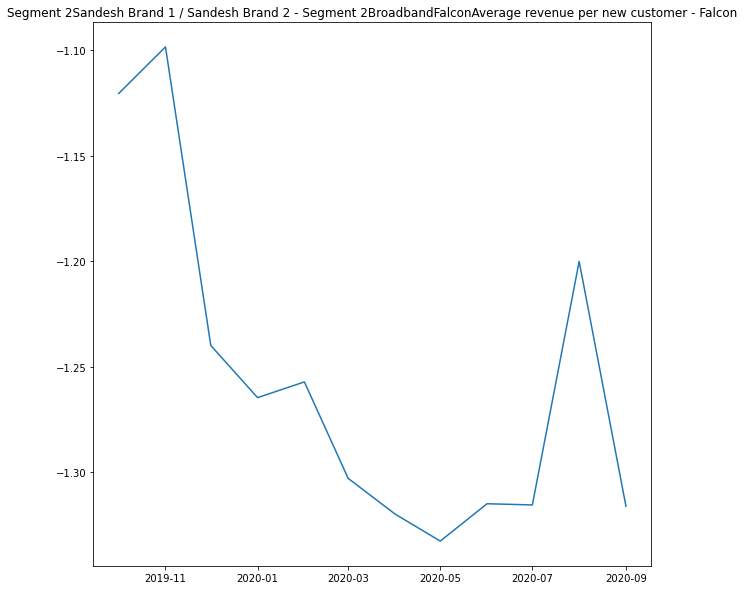

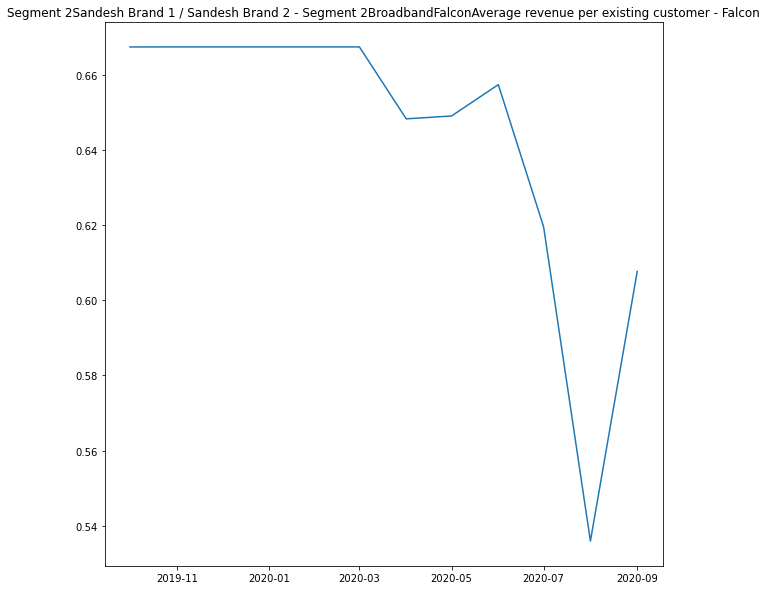

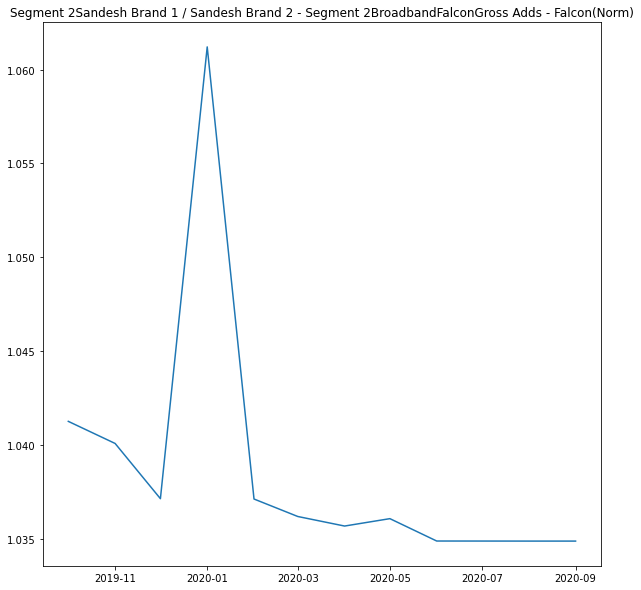

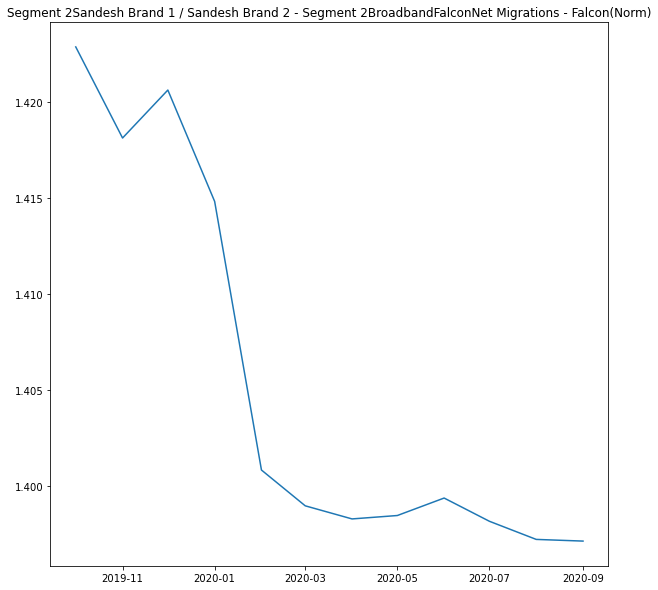

In [123]:
for col in df_ensemble_test_pred.columns.values[1:]:
    plt.figure(figsize=(10,10))
    plt.plot(df_ensemble_test_pred.Date, df_ensemble_test_pred[col])
    plt.title(col)
    plt.show()

In [124]:
df_regression_sarimax_test_pred = df_ensemble_test_pred.copy()

In [125]:
all_score_df

cols regression_raw  \
0  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...       0.896848   
1  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...       0.741826   
2  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...       0.726026   
3  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...       0.933598   

  regression_mape sarimax_raw sarimax_mape               lstm_raw lstm_mape  \
0         10.3152     0.91993      8.00699                 0.8741     12.59   
1         49.4793    0.733169      26.6831  [0.11413684045338028]   89.0479   
2         27.3973    0.537873      66.9225   [0.2017434092764084]   244.575   
3         6.64018     0.31986      70.7368  [0.14272703809666434]   128.727   

   regression_sarimax_raw  regression_sarimax_mape  
0                0.983829                 1.617084  
1                0.983667                 1.633344  
2                0.970651                 2.934933  
3                0.969815                 3.018485

In [126]:
## Doing stacked ensemble using Support Vector Machine regression
regression_sarimax_lstm_score_params = {}
df_ensemble_test_pred = pd.DataFrame({})
for i in tqdm(range(df_sarimax_val_pred.shape[1])):
    col = df_sarimax_val_pred.columns.values[i]
    X = pd.concat([df_sarimax_val_pred.iloc[:,i].reset_index(drop=True),
                   df_val_pred.iloc[:,i].reset_index(drop=True),
                   df_lstm_val_pred.iloc[:,i].reset_index(drop=True)
                  ], 
                  axis=1).values
    y = df_sarimax_val_true.iloc[:,i].values
    epsilon_params = np.arange(0.01,0.5,0.001)
    min_ensemble_rmse_score = 9999
    min_ensemble_mape_score = 9999
    min_ensemble_raw_score = -99
    best_eps = 0.2
    for eps in epsilon_params:
        clf = SVR(kernel='rbf', C=1.0, epsilon=eps)
        clf.fit(X,y)
        y_hat = clf.predict(X)
        rmse_score = scoring_rmse(y,y_hat)
        mape_score = scoring(y,y_hat)
        raw_score = raw_scoring(y, y_hat)
        if raw_score > min_ensemble_raw_score:
            min_ensemble_rmse_score = rmse_score
            min_ensemble_mape_score = mape_score
            min_ensemble_raw_score = raw_score
            best_eps = eps
    print(f"Best Ensemble RMSE Score for {col} is :{min_ensemble_rmse_score}")
    print(f"Best Ensemble MAPE Score for {col} is : {min_ensemble_mape_score}")
    print(f"Best Ensemble RAW Score for {col} is : {min_ensemble_raw_score}")
    print("Best Epsilon value :",best_eps)
    regression_sarimax_lstm_score_params[col] = {"raw_score":min_ensemble_raw_score,
                                            "mape_score":min_ensemble_mape_score,
                                            "params":best_eps
                                            }
    clf = SVR(kernel='rbf', C=1.0, epsilon=best_eps)
    clf.fit(X,y)
    if col == 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon':
        col_short = 'Falcon_ARPU_New'
    elif col == 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon':
        col_short = 'Falcon_ARPU_Existing'
    elif col == 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)':
        col_short = 'Falcon_Gross_Adds'
    else:
        col_short = 'Falcon_Net_Migration'
    joblib.dump(clf, "../ensemble_weights/"+col_short+"regression_sarimax_lstm_ensemble.dump")
    y_hat = clf.predict(X)
    print(f"Best model MAPE for column {col} is {scoring(y,y_hat)}")
    print(f"Best Model RMSE for column {col} is {scoring_rmse(y,y_hat)}")
    print(f"Best Model RAW for column {col} is: {raw_scoring(y,y_hat)}")
    X_test = pd.concat([df_sarimax_test_pred.iloc[:,i+1].reset_index(drop=True),
                   df_test_pred.iloc[:,i+1].reset_index(drop=True),
                        df_lstm_test_pred.iloc[:,i+1].reset_index(drop=True)
                       ], 
                  axis=1).values
    y_test = clf.predict(X_test)
    
    df_ensemble_test_pred[col] = y_test
    
#     if np.any(excptn_2_smooth==col):
#         df_ensemble_test_pred[col] = df_sarimax_test_pred[col]
#     else:
#         df_ensemble_test_pred[col] = y_test

 25%|██▌       | 1/4 [00:00<00:00,  5.00it/s]

Best Ensemble RMSE Score for Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon is :0.03140539189300603
Best Ensemble MAPE Score for Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon is : 1.7257005867668502
Best Ensemble RAW Score for Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon is : 0.9827430075142604
Best Epsilon value : 0.01
Best model MAPE for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon is 1.7257005867668502
Best Model RMSE for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon is 0.03140539189300603
Best Model RAW for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon is: 0.9827430075142604
Be

 50%|█████     | 2/4 [00:00<00:00,  5.01it/s]

Best model MAPE for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon is 14.32430095660648
Best Model RMSE for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon is 0.10510440738504133
Best Model RAW for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon is: 0.8567565786211772


 75%|███████▌  | 3/4 [00:00<00:00,  4.74it/s]

Best Ensemble RMSE Score for Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm) is :0.1951054141180309
Best Ensemble MAPE Score for Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm) is : 8.757348064669984
Best Ensemble RAW Score for Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm) is : 0.9124264500880862
Best Epsilon value : 0.01
Best model MAPE for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm) is 8.757348064669984
Best Model RMSE for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm) is 0.1951054141180309
Best Model RAW for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm) is: 0.9124264500880862


100%|██████████| 4/4 [00:00<00:00,  4.29it/s]

Best Ensemble RMSE Score for Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm) is :0.0713017084952936
Best Ensemble MAPE Score for Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm) is : 3.5059457343060907
Best Ensemble RAW Score for Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm) is : 0.964940516132092
Best Epsilon value : 0.01
Best model MAPE for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm) is 3.5059457343060907
Best Model RMSE for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm) is 0.0713017084952936
Best Model RAW for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm) is: 0.964940516132092


In [127]:
regression_sarimax_lstm_score_params

{'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon': {'raw_score': 0.9827430075142604,
  'mape_score': 1.7257005867668502,
  'params': 0.01},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon': {'raw_score': 0.8567565786211772,
  'mape_score': 14.32430095660648,
  'params': 0.01},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)': {'raw_score': 0.9124264500880862,
  'mape_score': 8.757348064669984,
  'params': 0.01},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)': {'raw_score': 0.964940516132092,
  'mape_score': 3.5059457343060907,
  'params': 0.01}}

In [128]:
regression_sarimax_lstm_score_df = \
pd.DataFrame(regression_sarimax_lstm_score_params).T.reset_index().iloc[:,:3].\
rename(columns={"index":"cols",
                "raw_score":"regression_sarimax_lstm_raw",
                "mape_score":"regression_sarimax_lstm_mape"
               })

In [129]:
all_score_df = pd.merge(all_score_df,regression_sarimax_lstm_score_df)

In [130]:
df_ensemble_test_pred.index = df_sarimax_test_pred["Date"]

In [131]:
df_ensemble_test_pred.reset_index(inplace=True)

In [132]:
df_regression_sarimax_lstm_test_pred = df_ensemble_test_pred.copy()

In [133]:
all_score_df

cols regression_raw  \
0  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...       0.896848   
1  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...       0.741826   
2  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...       0.726026   
3  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...       0.933598   

  regression_mape sarimax_raw sarimax_mape               lstm_raw lstm_mape  \
0         10.3152     0.91993      8.00699                 0.8741     12.59   
1         49.4793    0.733169      26.6831  [0.11413684045338028]   89.0479   
2         27.3973    0.537873      66.9225   [0.2017434092764084]   244.575   
3         6.64018     0.31986      70.7368  [0.14272703809666434]   128.727   

   regression_sarimax_raw  regression_sarimax_mape  \
0                0.983829                 1.617084   
1                0.983667                 1.633344   
2                0.970651                 2.934933   
3                0.969815                 3.018485   

   regression_sarimax_lstm_raw  regression_sarimax_lstm_mape  
0                     0.982743                      1.725701  
1                     0.856757                     14.324301  
2                     0.912426                      8.757348  
3                     0.964941                      3.505946

In [134]:
## Doing stacked ensemble using Support Vector Machine regression
sarimax_lstm_score_params = {}
df_ensemble_test_pred = pd.DataFrame({})
for i in tqdm(range(df_sarimax_val_pred.shape[1])):
    col = df_sarimax_val_pred.columns.values[i]
    X = pd.concat([df_sarimax_val_pred.iloc[:,i].reset_index(drop=True),
#                    df_val_pred.iloc[:,i].reset_index(drop=True),
                   df_lstm_val_pred.iloc[:,i].reset_index(drop=True)
                  ], 
                  axis=1).values
    y = df_sarimax_val_true.iloc[:,i].values
    epsilon_params = np.arange(0.01,0.5,0.001)
    min_ensemble_rmse_score = 9999
    min_ensemble_mape_score = 9999
    min_ensemble_raw_score = -99
    best_eps = 0.2
    for eps in epsilon_params:
        clf = SVR(kernel='rbf', C=1.0, epsilon=eps)
        clf.fit(X,y)
        y_hat = clf.predict(X)
        rmse_score = scoring_rmse(y,y_hat)
        mape_score = scoring(y,y_hat)
        raw_score = raw_scoring(y, y_hat)
        if raw_score > min_ensemble_raw_score:
            min_ensemble_rmse_score = rmse_score
            min_ensemble_mape_score = mape_score
            min_ensemble_raw_score = raw_score
            best_eps = eps
    print(f"Best Ensemble RMSE Score : {min_ensemble_rmse_score}")
    print(f"Best Ensemble MAPE Score : {min_ensemble_mape_score}")
    print(f"Best Ensemble RAW Score : {min_ensemble_raw_score}")
    print("Best Epsilon value :",best_eps)
    sarimax_lstm_score_params[col] = {"raw_score":min_ensemble_raw_score,
                                      "mape_score":min_ensemble_mape_score,
                                      "params":best_eps
                                     }
    clf = SVR(kernel='rbf', C=1.0, epsilon=best_eps)
    clf.fit(X,y)
    if col == 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon':
        col_short = 'Falcon_ARPU_New'
    elif col == 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon':
        col_short = 'Falcon_ARPU_Existing'
    elif col == 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)':
        col_short = 'Falcon_Gross_Adds'
    else:
        col_short = 'Falcon_Net_Migration'
    joblib.dump(clf,"../ensemble_weights/"+col_short+"sarimax_lstm_ensemble.dump")
    y_hat = clf.predict(X)
    print(f"Best model MAPE for column {col} is {scoring(y,y_hat)}")
    print(f"Best Model RMSE for column {col} is {scoring_rmse(y,y_hat)}")
    print(f"Best Model RAW for column {col} is {raw_scoring(y,y_hat)}")
    X_test = pd.concat([df_sarimax_test_pred.iloc[:,i+1].reset_index(drop=True),
#                    df_test_pred.iloc[:,i+1].reset_index(drop=True),
                        df_lstm_test_pred.iloc[:,i+1].reset_index(drop=True)
                       ], 
                  axis=1).values
    y_test = clf.predict(X_test)
    
    df_ensemble_test_pred[col] = y_test
    
#     if np.any(excptn_2_smooth==col):
#         df_ensemble_test_pred[col] = df_sarimax_test_pred[col]
#     else:
#         df_ensemble_test_pred[col] = y_test

 25%|██▌       | 1/4 [00:00<00:00,  4.17it/s]

Best Ensemble RMSE Score : 0.010045940977062252
Best Ensemble MAPE Score : 0.7592686606363472
Best Ensemble RAW Score : 0.9924073192211508
Best Epsilon value : 0.01
Best model MAPE for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon is 0.7592686606363472
Best Model RMSE for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon is 0.010045940977062252
Best Model RAW for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon is 0.9924073192211508


 50%|█████     | 2/4 [00:00<00:00,  3.82it/s]

Best Ensemble RMSE Score : 0.04330455387147617
Best Ensemble MAPE Score : 4.6243787338940345
Best Ensemble RAW Score : 0.9537561392906926
Best Epsilon value : 0.01
Best model MAPE for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon is 4.6243787338940345
Best Model RMSE for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon is 0.04330455387147617
Best Model RAW for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon is 0.9537561392906926


 75%|███████▌  | 3/4 [00:00<00:00,  3.60it/s]

Best Ensemble RMSE Score : 0.17576967965197154
Best Ensemble MAPE Score : 11.032067707996655
Best Ensemble RAW Score : 0.8896792090184674
Best Epsilon value : 0.01
Best model MAPE for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm) is 11.032067707996655
Best Model RMSE for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm) is 0.17576967965197154
Best Model RAW for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm) is 0.8896792090184674
Best Ensemble RMSE Score : 0.1741771564904257
Best Ensemble MAPE Score : 10.647233344283467
Best Ensemble RAW Score : 0.8935275826386873
Best Epsilon value : 0.01


100%|██████████| 4/4 [00:01<00:00,  3.75it/s]

Best model MAPE for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm) is 10.647233344283467
Best Model RMSE for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm) is 0.1741771564904257
Best Model RAW for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm) is 0.8935275826386873


In [135]:
sarimax_lstm_score_params

{'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon': {'raw_score': 0.9924073192211508,
  'mape_score': 0.7592686606363472,
  'params': 0.01},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon': {'raw_score': 0.9537561392906926,
  'mape_score': 4.6243787338940345,
  'params': 0.01},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)': {'raw_score': 0.8896792090184674,
  'mape_score': 11.032067707996655,
  'params': 0.01},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)': {'raw_score': 0.8935275826386873,
  'mape_score': 10.647233344283467,
  'params': 0.01}}

In [136]:
sarimax_lstm_score_df = \
pd.DataFrame(sarimax_lstm_score_params).T.reset_index().iloc[:,:3].\
rename(columns={"index":"cols",
                "raw_score":"sarimax_lstm_raw",
                "mape_score":"sarimax_lstm_mape"
               })

In [137]:
all_score_df = pd.merge(all_score_df,sarimax_lstm_score_df)

In [138]:
df_ensemble_test_pred.index = df_sarimax_test_pred["Date"]

In [139]:
df_ensemble_test_pred.reset_index(inplace=True)

In [140]:
df_sarimax_lstm_test_pred = df_ensemble_test_pred.copy()

In [141]:
all_score_df

cols regression_raw  \
0  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...       0.896848   
1  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...       0.741826   
2  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...       0.726026   
3  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...       0.933598   

  regression_mape sarimax_raw sarimax_mape               lstm_raw lstm_mape  \
0         10.3152     0.91993      8.00699                 0.8741     12.59   
1         49.4793    0.733169      26.6831  [0.11413684045338028]   89.0479   
2         27.3973    0.537873      66.9225   [0.2017434092764084]   244.575   
3         6.64018     0.31986      70.7368  [0.14272703809666434]   128.727   

   regression_sarimax_raw  regression_sarimax_mape  \
0                0.983829                 1.617084   
1                0.983667                 1.633344   
2                0.970651                 2.934933   
3                0.969815                 3.018485   

   regression_sarimax_lstm_raw  regression_sarimax_lstm_mape  \
0                     0.982743                      1.725701   
1                     0.856757                     14.324301   
2                     0.912426                      8.757348   
3                     0.964941                      3.505946   

   sarimax_lstm_raw  sarimax_lstm_mape  
0          0.992407           0.759269  
1          0.953756           4.624379  
2          0.889679          11.032068  
3          0.893528          10.647233

In [142]:
## Doing stacked ensemble using Support Vector Machine regression
regression_lstm_score_params = {}
df_ensemble_test_pred = pd.DataFrame({})
for i in tqdm(range(df_sarimax_val_pred.shape[1])):
    col = df_sarimax_val_pred.columns.values[i]
    X = pd.concat([
                   df_val_pred.iloc[:,i].reset_index(drop=True),
#                     df_sarimax_val_pred.iloc[:,i].reset_index(drop=True),
                   df_lstm_val_pred.iloc[:,i].reset_index(drop=True)
                  ], 
                  axis=1).values
    y = df_sarimax_val_true.iloc[:,i].values
    epsilon_params = np.arange(0.01,0.5,0.001)
    min_ensemble_rmse_score = 9999
    min_ensemble_mape_score = 9999
    min_ensemble_raw_score = -99
    best_eps = 0.2
    for eps in epsilon_params:
        clf = SVR(kernel='rbf', C=1.0, epsilon=eps)
        clf.fit(X,y)
        y_hat = clf.predict(X)
        rmse_score = scoring_rmse(y,y_hat)
        mape_score = scoring(y,y_hat)
        raw_score = raw_scoring(y, y_hat)
        if raw_score > min_ensemble_raw_score:
            min_ensemble_rmse_score = rmse_score
            min_ensemble_mape_score = mape_score
            min_ensemble_raw_score = raw_score
            best_eps = eps
    print(f"Best Ensemble RMSE Score : {min_ensemble_rmse_score}")
    print(f"Best Ensemble MAPE Score : {min_ensemble_mape_score}")
    print(f"Best Ensemble RAW Score : {min_ensemble_raw_score}")
    print("Best Epsilon value :",best_eps)
    regression_lstm_score_params[col] = {"raw_score":min_ensemble_raw_score,
                                      "mape_score":min_ensemble_mape_score,
                                      "params":best_eps
                                     }
    clf = SVR(kernel='rbf', C=1.0, epsilon=best_eps)
    clf.fit(X,y)
    if col == 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon':
        col_short = 'Falcon_ARPU_New'
    elif col == 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon':
        col_short = 'Falcon_ARPU_Existing'
    elif col == 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)':
        col_short = 'Falcon_Gross_Adds'
    else:
        col_short = 'Falcon_Net_Migration'
    joblib.dump(clf, "../ensemble_weights/"+col_short+"regression_lstm_ensemble.dump")
    y_hat = clf.predict(X)
    print(f"Best model MAPE for column {col} is {scoring(y,y_hat)}")
    print(f"Best Model RMSE for column {col} is {scoring_rmse(y,y_hat)}")
    print(f"Best Model RAW for column {col} is {raw_scoring(y,y_hat)}")
    X_test = pd.concat([
                   df_test_pred.iloc[:,i+1].reset_index(drop=True),
#                     df_sarimax_test_pred.iloc[:,i+1].reset_index(drop=True),
                        df_lstm_test_pred.iloc[:,i+1].reset_index(drop=True)
                       ], 
                  axis=1).values
    y_test = clf.predict(X_test)
    
    df_ensemble_test_pred[col] = y_test
    
#     if np.any(excptn_2_smooth==col):
#         df_ensemble_test_pred[col] = df_sarimax_test_pred[col]
#     else:
#         df_ensemble_test_pred[col] = y_test

 25%|██▌       | 1/4 [00:00<00:00,  3.42it/s]

Best Ensemble RMSE Score : 0.06445628855976378
Best Ensemble MAPE Score : 3.1109152401374454
Best Ensemble RAW Score : 0.9688908715880271
Best Epsilon value : 0.01
Best model MAPE for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon is 3.1109152401374454
Best Model RMSE for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon is 0.06445628855976378
Best Model RAW for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon is 0.9688908715880271


 50%|█████     | 2/4 [00:00<00:00,  3.45it/s]

Best Ensemble RMSE Score : 0.2677824490346718
Best Ensemble MAPE Score : 35.35352990060454
Best Ensemble RAW Score : 0.8138718614290941
Best Epsilon value : 0.01
Best model MAPE for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon is 35.35352990060454
Best Model RMSE for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon is 0.2677824490346718
Best Model RAW for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon is 0.8138718614290941


100%|██████████| 4/4 [00:00<00:00,  4.07it/s]

Best Ensemble RMSE Score : 0.19576949821589962
Best Ensemble MAPE Score : 8.76073563815598
Best Ensemble RAW Score : 0.9123925753500699
Best Epsilon value : 0.01
Best model MAPE for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm) is 8.76073563815598
Best Model RMSE for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm) is 0.19576949821589962
Best Model RAW for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm) is 0.9123925753500699
Best Ensemble RMSE Score : 0.07140958579305877
Best Ensemble MAPE Score : 3.4606369503707053
Best Ensemble RAW Score : 0.9653936044711232
Best Epsilon value : 0.01
Best model MAPE for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm) is 3.4606369503707053
Best Model RMSE for column Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalcon

In [143]:
regression_lstm_score_params

{'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon': {'raw_score': 0.9688908715880271,
  'mape_score': 3.1109152401374454,
  'params': 0.01},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon': {'raw_score': 0.8138718614290941,
  'mape_score': 35.35352990060454,
  'params': 0.01},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)': {'raw_score': 0.9123925753500699,
  'mape_score': 8.76073563815598,
  'params': 0.01},
 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)': {'raw_score': 0.9653936044711232,
  'mape_score': 3.4606369503707053,
  'params': 0.01}}

In [144]:
regression_lstm_score_df = \
pd.DataFrame(regression_lstm_score_params).T.reset_index().iloc[:,:3].\
rename(columns={"index":"cols",
                "raw_score":"regression_lstm_raw",
                "mape_score":"regression_lstm_mape"
               })

In [145]:
all_score_df = pd.merge(all_score_df,regression_lstm_score_df)

In [146]:
all_score_df

cols regression_raw  \
0  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...       0.896848   
1  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...       0.741826   
2  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...       0.726026   
3  Segment 2Sandesh Brand 1 / Sandesh Brand 2 - S...       0.933598   

  regression_mape sarimax_raw sarimax_mape               lstm_raw lstm_mape  \
0         10.3152     0.91993      8.00699                 0.8741     12.59   
1         49.4793    0.733169      26.6831  [0.11413684045338028]   89.0479   
2         27.3973    0.537873      66.9225   [0.2017434092764084]   244.575   
3         6.64018     0.31986      70.7368  [0.14272703809666434]   128.727   

   regression_sarimax_raw  regression_sarimax_mape  \
0                0.983829                 1.617084   
1                0.983667                 1.633344   
2                0.970651                 2.934933   
3                0.969815                 3.018485   

   regression_sarimax_lstm_raw  regression_sarimax_lstm_mape  \
0                     0.982743                      1.725701   
1                     0.856757                     14.324301   
2                     0.912426                      8.757348   
3                     0.964941                      3.505946   

   sarimax_lstm_raw  sarimax_lstm_mape  regression_lstm_raw  \
0          0.992407           0.759269             0.968891   
1          0.953756           4.624379             0.813872   
2          0.889679          11.032068             0.912393   
3          0.893528          10.647233             0.965394   

   regression_lstm_mape  
0              3.110915  
1             35.353530  
2              8.760736  
3              3.460637

In [147]:
df_ensemble_test_pred.index = df_sarimax_test_pred["Date"]

In [148]:
df_ensemble_test_pred.reset_index(inplace=True)

In [149]:
df_regression_lstm_test_pred = df_ensemble_test_pred.copy()

In [150]:
df_sarimax_val_pred

Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon  \
2019-04-01                                          -1.303207                                                                
2019-05-01                                          -1.365763                                                                
2019-06-01                                          -1.327848                                                                
2019-07-01                                          -1.293639                                                                
2019-08-01                                          -1.359063                                                                
2019-09-01                                          -1.323156                                                                

            Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon  \
2019-04-01                                           0.974777                                                                     
2019-05-01                                           0.994910                                                                     
2019-06-01                                           0.929670                                                                     
2019-07-01                                           0.899205                                                                     
2019-08-01                                           0.729968                                                                     
2019-09-01                                           0.578980                                                                     

            Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)  \
2019-04-01                                           0.572192                                                
2019-05-01                                           0.627248                                                
2019-06-01                                           1.092781                                                
2019-07-01                                           1.033568                                                
2019-08-01                                           1.088624                                                
2019-09-01                                           1.554157                                                

            Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)  
2019-04-01                                           0.033902                                                   
2019-05-01                                           0.088780                                                   
2019-06-01                                           0.281871                                                   
2019-07-01                                           0.289190                                                   
2019-08-01                                           0.310821                                                   
2019-09-01                                           0.349786

In [151]:
all_mape_score_df = \
all_score_df[["cols",
              "regression_mape",
              "sarimax_mape",
              "regression_sarimax_mape",
              "lstm_mape",
              "regression_sarimax_lstm_mape",
              "sarimax_lstm_mape",
              "regression_lstm_mape"
             ]]

In [152]:
all_mape_score_df_pivot = all_mape_score_df.set_index("cols").T



In [153]:
all_mape_score_df_pivot

cols                         Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon  \
regression_mape                                                         10.3152                                                               
sarimax_mape                                                            8.00699                                                               
regression_sarimax_mape                                                 1.61708                                                               
lstm_mape                                                                 12.59                                                               
regression_sarimax_lstm_mape                                             1.7257                                                               
sarimax_lstm_mape                                                      0.759269                                                               
regression_lstm_mape                                                    3.11092                                                               

cols                         Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon  \
regression_mape                                                         49.4793                                                                    
sarimax_mape                                                            26.6831                                                                    
regression_sarimax_mape                                                 1.63334                                                                    
lstm_mape                                                               89.0479                                                                    
regression_sarimax_lstm_mape                                            14.3243                                                                    
sarimax_lstm_mape                                                       4.62438                                                                    
regression_lstm_mape                                                    35.3535                                                                    

cols                         Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)  \
regression_mape                                                         27.3973                                               
sarimax_mape                                                            66.9225                                               
regression_sarimax_mape                                                 2.93493                                               
lstm_mape                                                               244.575                                               
regression_sarimax_lstm_mape                                            8.75735                                               
sarimax_lstm_mape                                                       11.0321                                               
regression_lstm_mape                                                    8.76074                                               

cols                         Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)  
regression_mape                                                         6.64018                                                  
sarimax_mape                                                            70.7368                                                  
regression_sarimax_mape                                                 3.01849                                                  
lstm_mape                                                               128.727                                                  
reg

In [154]:
all_raw_score_df = \
all_score_df[["cols",
              "regression_raw",
              "sarimax_raw",
              "regression_sarimax_raw",
              "lstm_raw",
              "regression_sarimax_lstm_raw",
              "sarimax_lstm_raw",
              "regression_lstm_raw"
             ]]

In [155]:
all_raw_score_df_pivot = all_raw_score_df.set_index("cols").T

In [156]:
all_raw_score_df_pivot

cols                        Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon  \
regression_raw                                                        0.896848                                                               
sarimax_raw                                                            0.91993                                                               
regression_sarimax_raw                                                0.983829                                                               
lstm_raw                                                                0.8741                                                               
regression_sarimax_lstm_raw                                           0.982743                                                               
sarimax_lstm_raw                                                      0.992407                                                               
regression_lstm_raw                                                   0.968891                                                               

cols                        Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon  \
regression_raw                                                        0.741826                                                                    
sarimax_raw                                                           0.733169                                                                    
regression_sarimax_raw                                                0.983667                                                                    
lstm_raw                                                 [0.11413684045338028]                                                                    
regression_sarimax_lstm_raw                                           0.856757                                                                    
sarimax_lstm_raw                                                      0.953756                                                                    
regression_lstm_raw                                                   0.813872                                                                    

cols                        Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)  \
regression_raw                                                        0.726026                                               
sarimax_raw                                                           0.537873                                               
regression_sarimax_raw                                                0.970651                                               
lstm_raw                                                  [0.2017434092764084]                                               
regression_sarimax_lstm_raw                                           0.912426                                               
sarimax_lstm_raw                                                      0.889679                                               
regression_lstm_raw                                                   0.912393                                               

cols                        Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)  
regression_raw                                                        0.933598                                                  
sarimax_raw                                                            0.31986                                                  
regression_sarimax_raw                                                0.969815                                                  
lstm_raw                                                 [0.14272703809666434]                                                  
regression_sarimax_lstm_raw     

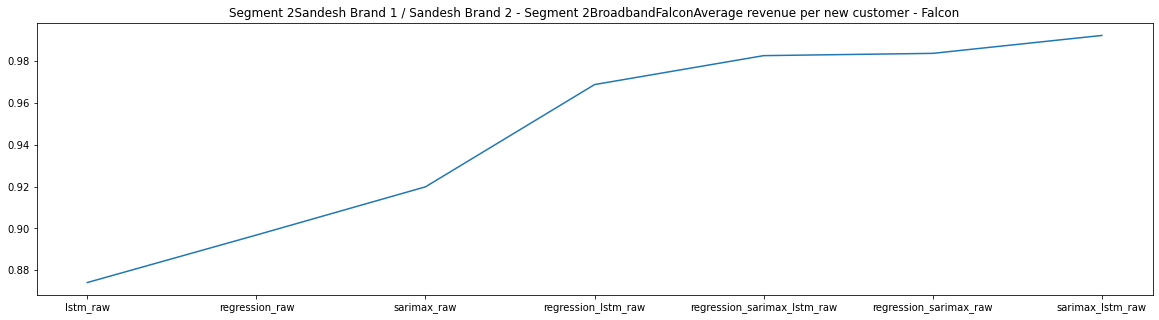

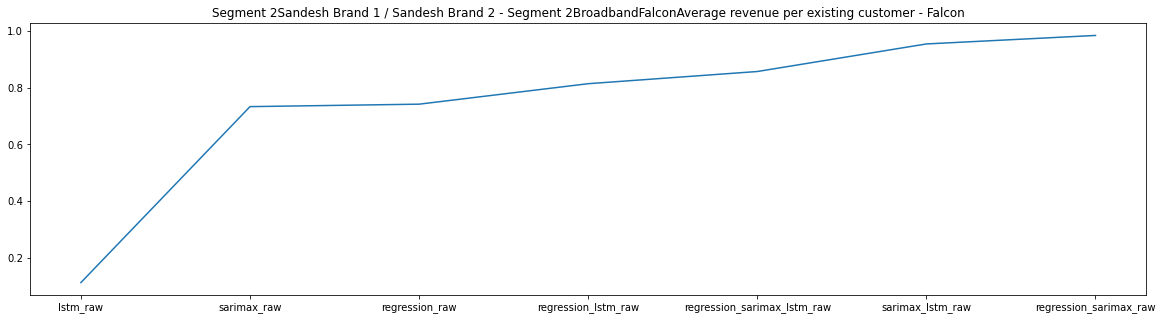

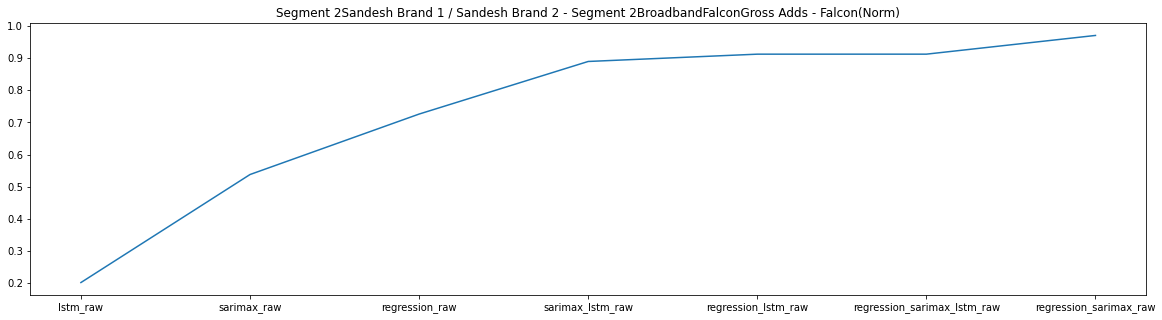

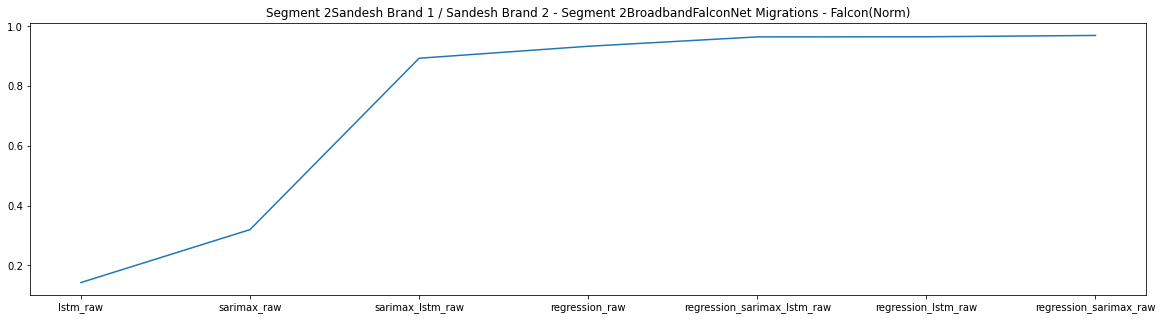

In [161]:
for col in all_raw_score_df_pivot.columns:
    all_raw_score_df_pivot[col].sort_values().\
    apply(lambda x: x[0] if isinstance(x, np.ndarray) else x).plot(figsize=(20,5))
    plt.title(col)
    plt.show()

From the above graph, one can identify which model should be used for which metric. Rules are as follows:

1.  Identify the Knee Structure in the graph where the raw score seems to be overfitting

After analysis one can identify the mapping as follows:

1. 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per new customer - Falcon' = "sarimax"
2. 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconAverage revenue per existing customer - Falcon' = "sarimax"
3. 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconGross Adds - Falcon(Norm)' = "sarimax_lstm"
4. 'Segment 2Sandesh Brand 1 / Sandesh Brand 2 - Segment 2BroadbandFalconNet Migrations - Falcon(Norm)' = "regression"
    